In [125]:
library(tidyverse)
library(repr)
options(repr.plot.width=8, repr.plot.height=6)
library(ggplot2)
library(broom)
library(gridExtra)
library(GGally)

library(latex2exp)

# Lecture 5: LR with different type of explanatory variables

## 1. Data

> **Research question**: are protein and mrna concentrations related??


In [126]:
prot <- read.csv("data/proteinUN.csv", row.names = 1)
prot <- prot %>% rownames_to_column(var = "gene") %>%  
        mutate(gene = as.factor(gene), na_count_prot = rowSums(is.na(.)))

mrna <- read.csv("data/geneUN.csv", row.names = 1)
mrna <- mrna %>% rownames_to_column(var = "gene") %>%  
        mutate(gene = as.factor(gene), na_count_mrna = rowSums(is.na(.)))

tissues <- colnames(mrna)
genes <- proteins <- prot$gene

In [127]:
prot_long <- gather(prot, tissue, protein, uterus:esophagus, factor_key=TRUE)
head(prot_long,3)

,gene,na_count_prot,tissue,protein
,<fct>,<dbl>,<fct>,<dbl>
1,ENSG00000000003,10,uterus,NA
2,ENSG00000000419,0,uterus,9.966484e-06
3,ENSG00000000457,7,uterus,NA


In [128]:
mrna_long <- gather(mrna, tissue, mrna, uterus:esophagus, factor_key=TRUE)
head(mrna_long,3)

,gene,na_count_mrna,tissue,mrna
,<fct>,<dbl>,<fct>,<dbl>
1,ENSG00000000003,0,uterus,2.50e-05
2,ENSG00000000419,0,uterus,3.44e-05
3,ENSG00000000457,0,uterus,7.80e-06


In [129]:
dat <- prot_long  %>%  full_join(mrna_long, by = c("gene","tissue"))
head(dat,3)

,gene,na_count_prot,tissue,protein,na_count_mrna,mrna
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,10,uterus,NA,0,2.50e-05
2,ENSG00000000419,0,uterus,9.966484e-06,0,3.44e-05
3,ENSG00000000457,7,uterus,NA,0,7.80e-06


> A quick look at one gene (there are 6104 genes in the dataset)

Nothing special about this one, but you can see that it has complete protein and mrna measurements for all genes 

In [130]:
dat_419 <- dat  %>% subset(gene=="ENSG00000000419")
dat_419

,gene,na_count_prot,tissue,protein,na_count_mrna,mrna
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
2,ENSG00000000419,0,uterus,9.966484e-06,0,3.44e-05
6106,ENSG00000000419,0,kidney,1.894265e-05,0,3.43e-05
12210,ENSG00000000419,0,testis,4.257907e-05,0,3.80e-05
18314,ENSG00000000419,0,pancreas,1.575567e-06,0,2.11e-05
24418,ENSG00000000419,0,stomach,3.282342e-05,0,2.96e-05
30522,ENSG00000000419,0,prostate,2.119753e-05,0,3.40e-05
36626,ENSG00000000419,0,ovary,3.916784e-05,0,3.17e-05
42730,ENSG00000000419,0,thyroid.gland,3.930635e-06,0,4.54e-05
48834,ENSG00000000419,0,adrenal.gland,1.016500e-05,0,5.01e-05


## 2. SLR: protein vs mrna (per gene)

#### 1). Model

In [131]:
tidy(lm(protein ~ mrna, data = dat_419))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.281122e-05,0.0000196728,1.667847,0.1263090
mrna,-3.652730e-01,0.5534749457,-0.659963,0.5241862


#### 2). Interpretation

***Slope***: for every unit increase in `mrna`, the protein level is predicted to increase in 4.027. This value is not significatly different from 0 at 5% significance.

- **Wrong conclusion**: We can't conclude that protein and mRNA are not related!!

- **Correct interpretation**: We fail to reject the null hypothesis that protein and mRNA are related for this: 

$$H_0: r_g = 0$$

We don't have enough evidence to conclude that protein and mRNA are related for this gene.

## 3. SLR: protein vs genes

#### 1). Model

> experiment on three genes only


The variable `gene` is a factor with 3 levels: 
> ENSG00000085733 (default reference), ENSG00000143553, ENSG00000168497

In [132]:
set.seed(561)
dat_3genes <- dat %>%
  subset(na_count_prot == 0 & na_count_mrna == 0) %>%
  subset(gene %in% sample(gene, 3))

We can study how protein levels differ among the 3 genes using a MLR with one categorical variable (3 levels)

#### $$\text{prot}_i=\beta_0 + \beta_2 G2_{i} + \beta_3 G3_{i} + \varepsilon_i$$

> The subscript $i$ is to identify each tissue.


> R names the dummy variables using the name of the factor followed by level. 


> As we saw in lect02 and lect03, the dummy variable `geneENSG00000148180` equals 1 for the concentration of gene ENSG00000148180, and 0 otherwise. Similarly for the other dummy variable

In [133]:
lm_g <- lm(protein ~ gene, data = dat_3genes)


model.matrix(lm_g) %>% head()

,(Intercept),geneENSG00000143553,geneENSG00000168497
715,1,0,0
3410,1,1,0
4640,1,0,1
6819,1,0,0
9514,1,1,0
10744,1,0,1


In [134]:
tidy(lm_g)

tidy(lm_g, conf.int = TRUE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.493068e-05,1.669801e-05,1.4930330,0.1449286955
geneENSG00000143553,-5.976718e-06,2.361455e-05,-0.2530947,0.8017650772
geneENSG00000168497,8.791982e-05,2.361455e-05,3.7231208,0.0007328853


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.493068e-05,1.669801e-05,1.4930330,0.1449286955,-9.041676e-06,5.890303e-05
geneENSG00000143553,-5.976718e-06,2.361455e-05,-0.2530947,0.8017650772,-5.402088e-05,4.206745e-05
geneENSG00000168497,8.791982e-05,2.361455e-05,3.7231208,0.0007328853,3.987566e-05,1.359640e-04


#### 2). Interpretation

- The mean protein concentration of gene ENSG00000143553 is not significantly different (5.976718e-06 units lower) from that of gene ENSG00000085733 (reference) at a 5% significance level. 

- The mean protein concentration of gene ENSG00000168497 is significantly different (8.791982e-05 units larger) from that of gene ENSG00000085733 (reference) at a significance level of 5%.

- Note that the difference between the sample means are very small. However, in terms of the variation observed in the data, these numbers are not so small. The `statistic` measures the difference in terms of the SE of the estimator!

In [135]:
dat_3genes %>%
  group_by(gene) %>%
  summarise(mean_prot = mean(protein))

`summarise()` ungrouping output (override with `.groups` argument)



gene,mean_prot
<fct>,<dbl>
ENSG00000085733,2.493068e-05
ENSG00000143553,1.895396e-05
ENSG00000168497,1.128505e-04


## **4. Additive model**

#### 1). Assumptions

#### $$\text{prot}_i=\beta_0 + \beta_1 \text{mrna}_{i} + \beta_2 \text{G2}_{i} + \beta_3 \text{G3}_{i} + \varepsilon_i$$


---
> #### <font color=salmon>The fundamental assumption</font> behind the *additive* model is that the relation between the response and the continuous variable(s) remains constant for all values of the other variables!! 

> #### <font color=salmon> In our example, we are assuming that the relation between protein and mRNA is the same *for all genes*! </font>
---

The variables $G2$ and $G3$ are dummy variables that take only 2 values, 0 and 1

> $G2 = 1$ for gene ENSG00000143553, and it's $0$ otherwise 

> $G3 = 1$ for gene ENSG00000168497, and it's $0$ otherwise


> as before, we use 2 dummy variables to model 3 levels of a categorical variable

Let's take a closer look at our model:

- for gene ENSG00000085733, $G2=0$ and $G3=0$ : then 

$$\text{prot}_i=\beta_0 + \beta_1 \text{mrna}_{i} + \varepsilon_i$$

> just replace the dummy variables with 0, respectively, in the equation above

> this is just a SLR with intercept $\beta_0$ and slope $\beta_1$ to model the relation between `protein` and `mrna`!!

- for gene ENSG00000143553, $G2=1$ and $G3=0$: then 

$$\text{prot}_i=\beta_0 + \beta_1 \text{mrna}_{i} + \beta_2  + \varepsilon_i$$ 

> just replace the dummies with 1 and 0, respectively, in the equation above

> this is just a SLR with *the same* slope $\beta_1$ to model the relation between `protein` and `mrna`!!

> but note that in this case the intercept is *different*: $\beta_0 + \beta_2$

- for gene ENSG00000168497, $G2=0$ and $G3=1$: then 

$$\text{prot}_i=\beta_0 + \beta_1 \text{mrna}_{i} + \beta_3  + \varepsilon_i$$ 

> just replace the dummies with 0 and 1, respectively, in the equation above

> this is just a SLR with *the same* slope $\beta_1$ to model the relation between `protein` and `mrna`!!

> but note that in this case the intercept is *different*: $\beta_0 + \beta_3$

#### 2). Model

In [136]:
lm_g_mrna <- lm(protein ~ gene + mrna, dat_3genes)
model.matrix(lm_g_mrna) %>% head()

,(Intercept),geneENSG00000143553,geneENSG00000168497,mrna
715,1,0,0,0.0001278
3410,1,1,0,0.0000279
4640,1,0,1,0.0000415
6819,1,0,0,0.0000673
9514,1,1,0,0.0000247
10744,1,0,1,0.0000202


In [137]:
tidy(lm_g_mrna)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.970840e-05,4.091307e-05,-0.7261349,0.4730341541
geneENSG00000143553,3.446627e-05,3.617459e-05,0.9527759,0.3478455325
geneENSG00000168497,1.220579e-04,3.297606e-05,3.7014098,0.0008038126
mrna,6.043032e-01,4.144523e-01,1.4580767,0.1545649197


#### 3). Visualization

In [138]:
# estimated parameters for each line
est_g1a <- lm_g_mrna$coeff[c(1, 4)]
est_g2a <- c(sum(lm_g_mrna$coeff[1:2]), lm_g_mrna$coeff[4])
est_g3a <- c(sum(lm_g_mrna$coeff[c(1, 3)]), lm_g_mrna$coeff[4])

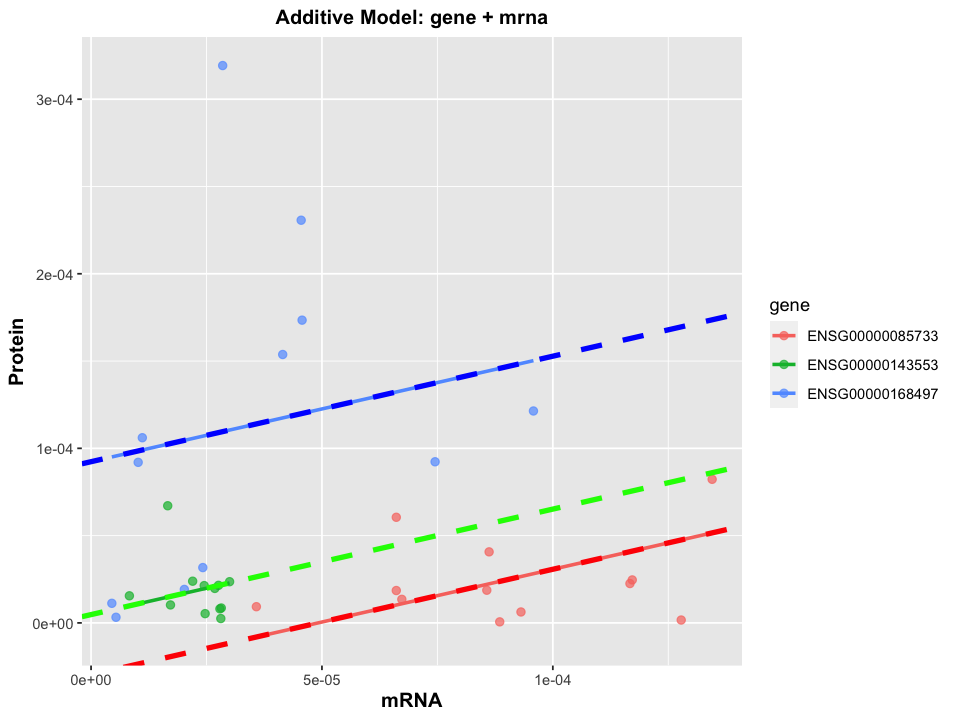

In [139]:
dat_3genes$pred_add <- predict(lm_g_mrna)


g_add <- ggplot(dat_3genes, aes(x = mrna, y = protein, color = gene)) +
  geom_point(alpha = .7, size = 2) +
  geom_line(aes(y = pred_add), size = 1) +
  labs(title = "Additive Model: gene + mrna", x = "mRNA", y = "Protein") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(face = "bold", size = 12)
  ) +
  geom_abline(intercept = est_g1a[1], slope = est_g1a[2], color = "red", linetype = "dashed", size=1.5) +
  geom_abline(intercept = est_g2a[1], slope = est_g2a[2], color = "green", linetype = "dashed", size=1.5) +
  geom_abline(intercept = est_g3a[1], slope = est_g3a[2], color = "blue", linetype = "dashed", size=1.5)


g_add

#### 4). Interpretation of `estimate`

#### $$\text{prot}_i=\beta_0 + \beta_1 \text{mrna}_{i} + \beta_2 \text{G2}_{i} + \beta_3 \text{G3}_{i} + \varepsilon_i$$



- The red line is the reference

- The 2nd estimate measures <b><font color=salmon>the difference of the estimated intercept of the green line and the red line</font></b>

- The 3rd estimate measures <b><font color=salmon>the difference of the estimated intercept of the blue line and the red line</font></b>

> - <b><font color=salmon> The parallel lines occur because we model a unique slope $\beta_1$ for both levels </font></b>
> - We assume that the relation between protein and mRNA is the same for all genes!!

This is not a data-driven result!! this is the model we fit!

In [140]:
tidy(lm_g_mrna)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.970840e-05,4.091307e-05,-0.7261349,0.4730341541
geneENSG00000143553,3.446627e-05,3.617459e-05,0.9527759,0.3478455325
geneENSG00000168497,1.220579e-04,3.297606e-05,3.7014098,0.0008038126
mrna,6.043032e-01,4.144523e-01,1.4580767,0.1545649197


#### 5). Interpretation of `p-value`


SE are estimated with results from asymptotic theory by `lm` but you can obtained them bootstrapping from the original sample!

The tests are as before "$H_0$: parameters=0" but the parameters have different meanings now:

- Is the intercept of the reference gene equal to 0?

$$H_0: \beta_0=0 \; vs \; H_1: \beta_0 \ne 0$$


- Is the intercept of the second gene that same as that of the reference gene? (similar for 3rd gene, $\beta_3$)

$$H_0: \beta_2=0 \; vs \; H_1: \beta_2 \ne 0$$


- Is the (common) slope equal to 0?

$$H_0: \beta_1=0 \; vs \; H_1: \beta_1 \ne 0$$

- **Computing by hand**

In [141]:
# statistic

summ_add <- tidy(lm_g_mrna)
data.frame(statistic = summ_add$statistic, my_statistic = summ_add$estimate / summ_add$std.error)

statistic,my_statistic
<dbl>,<dbl>
-0.7261349,-0.7261349
0.9527759,0.9527759
3.7014098,3.7014098
1.4580767,1.4580767


In [142]:
#degrees of freedom= n-p, n=36, p=4

lm_g_mrna$df

[1] 32

In [143]:
#pval for slope

data.frame(p.value=summ_add$p.value[4],
           my_pval=2*(1-pt(summ_add$statistic[4],lm_g_mrna$df)))

p.value,my_pval
<dbl>,<dbl>
0.1545649,0.1545649


## 5. MLR model with interaction effects

> - Is the fundamental assumption of the additive model true? (Is the relation between protein and mRNA the same for all genes??)

#### 1). Assumptions


> If we want to model different slopes for different genes, we need to add interaction terms in the model!
    
$$\text{prot}_i = \beta_0 + \beta_1 \text{mrna}_{i} + \beta_2 G2_{i}  + \beta_3 G3_{i}  + \beta_4 G2_{i} * \text{mrna}_{i} + \beta_5 G3_{i} * \text{mrna}_{i} +\varepsilon_i$$

> mathematically, we model the interaction adding more terms which are the multiplication of both variables

> note that the dummy variables changes the intercepts *and* the slopes of genes ENSG00000143553 and ENSG00000168497


#### Assumptions

An important difference to note between the additive and the model with interaction is that we are not assuming that groups share a slope!!

> lines are ***not*** parallel!!

The math is not difficult, just replace the dummy variables with 1 and 0 as before:


- when both dummies are zero: $\text{prot}_i = \beta_0 + \beta_1 \text{mrna}_{i}+\varepsilon_i$ (SLR for the reference line!)

The other 2 lines now have *different intercepts* and *different slopes*!!

- *Gene 2*: intercept = $\beta_0 + \beta_2$; slope = $\beta_1 + \beta_4$

- *Gene 3*: intercept = $\beta_0 + \beta_3$; slope = $\beta_1 + \beta_5$

> comparisons are *always* with respect to the reference gene!!


#### 2). Model

In [144]:
lm_gmrna <- lm(protein ~ gene * mrna, dat_3genes)

In [145]:
tidy(lm_gmrna)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.327928e-06,5.577621e-05,0.1134521,0.9104280
geneENSG00000143553,3.201698e-05,8.589540e-05,0.3727439,0.7119597
geneENSG00000168497,6.906928e-05,6.174779e-05,1.1185709,0.2722003
mrna,2.057447e-01,5.890193e-01,0.3493004,0.7293038
geneENSG00000143553:mrna,-1.031184e+00,2.753427e+00,-0.3745094,0.7106597
geneENSG00000168497:mrna,8.982580e-01,8.473966e-01,1.0600207,0.2975953


#### 3). Visualization

In [146]:
est_g1i <- lm_gmrna$coeff[c(1, 4)]
est_g2i <- c(sum(lm_gmrna$coeff[1:2]), sum(lm_gmrna$coeff[4:5]))
est_g3i <- c(sum(lm_gmrna$coeff[c(1, 3)]), sum(lm_gmrna$coeff[c(4, 6)]))

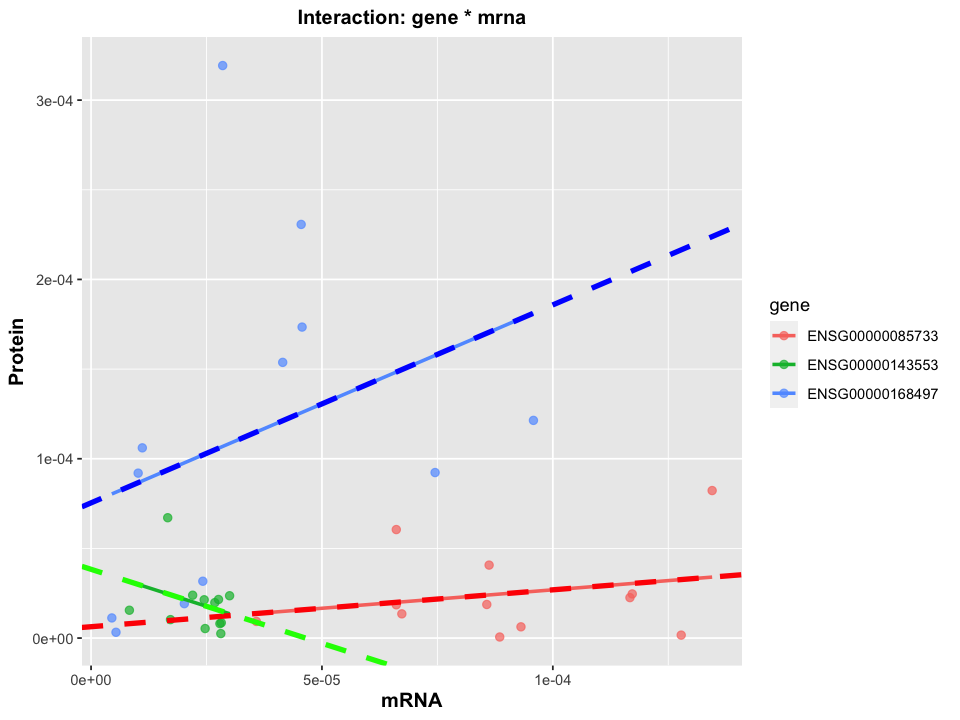

In [147]:
dat_3genes$pred_i <- predict(lm_gmrna)

g_i <- ggplot(dat_3genes, aes(x = mrna, y = protein, color = gene)) +
  geom_point(alpha = .7, size = 2) +
  geom_line(aes(y = pred_i), size = 1) +
  labs(title = "Interaction: gene * mrna", x = "mRNA", y = "Protein") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(face = "bold", size = 12)
  ) +
  geom_abline(intercept = est_g1i[1], slope = est_g1i[2], color = "red", linetype = "dashed", size=1.5) +
  geom_abline(intercept = est_g2i[1], slope = est_g2i[2], color = "green", linetype = "dashed", size=1.5) +
  geom_abline(intercept = est_g3i[1], slope = est_g3i[2], color = "blue", linetype = "dashed", size=1.5)

g_i

#### 4). Interpretation of `estimate`


#### $$\text{prot}_i = \beta_0 + \beta_1 \text{mrna}_{i} + \beta_2 G2_{i}  + \beta_3 G3_{i}  + \beta_4 G2_{i} * \text{mrna}_{i} + \beta_5 G3_{i} * \text{mrna}_{i} +\varepsilon_i$$


- **Intercept**
    - The estimate of (Intercept) ($\hat{\beta}_0$): is <b><font color=salmon>the estimated intercept of the SLR of the reference gene</font></b> ($G1$: ENSG00000085733, red line)

    - The estimate for `geneENSG00000143553` ($\hat{\beta}_2$): is <b><font color=salmon>the estimated difference between intercepts</font></b> of the SLR of $G2$ (ENSG00000143553) vs that of the reference gene ($G1$: ENSG00000085733) (green vs red lines)

    - The estimate for `geneENSG00000168497` ($\hat{\beta}_3$): is <b><font color=salmon>the estimated difference between intercepts</font></b> of the SLR of $G3$ vs that of the reference gene $G1$: ENSG00000085733 (blue vs red lines)
    
    
- **Slop**
    - The estimate for `mrna`, ($\hat{\beta}_1$), is <b><font color=salmon>the estimated slope of the SLR of the reference gene</font></b> ($G1$: ENSG00000085733, red line). 
        - It measures the predicted increase in the protein level for every unit increase in mRNA level for gene ENSG00000085733.
    - The estimate for `geneENSG00000143553:mrna` ($\hat{\beta}_4$): measures <b><font color=salmon>the difference of the estimated slopes</font></b> of the SLR of $G2$ vs that of $G1$ (difference of slopes of green vs red lines). 
        - It measures the *additional* change in protein level for every unit change in mRNA for $G2$ compared to the reference gene $G1$. 
    - The estimate for `geneENSG00000168497:mrna` ($\hat{\beta}_5$): measures <b><font color=salmon>the difference of the estimated slopes</font></b> of the SLR of $G3$ vs that of $G1$ (difference of slopes of green vs red lines). 
        - It measures the *additional* change in protein level for every unit change in mRNA for $G3$ compared to the reference gene $G1$. 

In [148]:
tidy(lm_gmrna)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.327928e-06,5.577621e-05,0.1134521,0.9104280
geneENSG00000143553,3.201698e-05,8.589540e-05,0.3727439,0.7119597
geneENSG00000168497,6.906928e-05,6.174779e-05,1.1185709,0.2722003
mrna,2.057447e-01,5.890193e-01,0.3493004,0.7293038
geneENSG00000143553:mrna,-1.031184e+00,2.753427e+00,-0.3745094,0.7106597
geneENSG00000168497:mrna,8.982580e-01,8.473966e-01,1.0600207,0.2975953


#### 5). Interpretation of `p-value`


All is the same. Let's look at the test of the *interaction term*

- Is the slope of gene ENSG00000143553 the same as the slope of the reference gene ENSG00000085733?

- Is the relation between protein and mRNA different for $G2$ compared to that of $G1$?

$$H_0: \beta_4=0 \; vs \; H_1: \beta_4 \ne 0$$

- Slopes look different in the plot! However, note that 
    - the slope of the reference gene is not significantly different from 0 (at 5% significance)
    - the slopes of other 2 genes are not significantly different from that of the reference (at 5% significance)

- For the 3 genes analyzed here (using LS), we don't have enough evidence to claim that the translation rates are specific for each gene.

> we do not reject the null hypothesis that the difference of the slopes is zero

## 6. Poll questions for L4

#### Q1: interpretation of test of hypothesis
> Suppose that you estimate a MLR to identify factors that influence the monthly sales of a new style of headphones (in \\$). If the p-value for investment in `advertisement` (in \\$) is 0.2 you can conclude that advertising is not related to sales. True or False? 

> Answer: False, we can't conclude that advertising is not related to sales. All we can say is that there's no evidence of an association.


The null hypothesis of test for the coefficient of `advertisement` will be:

$$ H_0: \beta = 0$$

where $\beta$ is the slope that relates `sales` with `advertisement`  

If the p-value of the test is 0.2, we don't have enough evidence to reject the null hypothesis. We fail to reject.

---

#### Q2: interpretation of CI

>  The 95\% confidence interval for advertisement is (1.2, 1.5). Then with 95\% confident you expect an average increase in sales of between \\$120 and \\$150 for every $100 increase in advertisement. True or False?

>   Answer: True, with 95\% conficent you expect an average increase in sales of between \\$120 and \\$150 for every $100 increase in advertisement 


This is the correct interpretation of a confidence interval (assuming that other variables in the model are fixed)! 

We constructed a confidence interval such that with 95\% probability, the interval contains the true regression coefficient. The interval is random since it depends on a random sample.

Once we get a sample and compute the confidence interval, (1.2, 1.5) in our case, there is no more randomness. This particular interval may or may not contain the true coefficient. We are 95\% confident it does (because of the way that it was constructed).
   


> Note that how to spell out the meaning of the coefficient in the interpretation of the CI, instead of saying "it contains the true coefficient" 

---

#### Q3: categorical explanatory variables

> Another variable in your model is `media`, a categorical variable with levels `YouTube`, `Facebook`, `Newspaper`, `Other`, that indicates where customers saw the adverticement. You can include this variable in the model using 3 dummy variables. True or False?

>  Answer: True, with these 3 (numerical) dummy variables we can include `media` in the LR


As a default, `lm` will create 3 dummy variables for you
> FYI: This way of including the variable `media` is known as the "treatment-reference" parametrization. We won't conver other parametrizations in this course.

Suppose that we code the variable `media` so that `Other` is the reference group. Then, `lm` creates the following dummy variables:

- `mediaYouTube`: equals 1 when a customer saw the add in YouTube, and it's 0 otherwise

- `mediaFacebook`: equals 1 when a customer saw the add in Facebook, and it's 0 otherwise

- `mediaNewspaper`: equals 1 when a customer saw the add in a newspaper, and it's 0 otherwise


---

#### Q4: interpretation of coefficients of dummy variables

> 4. The output of `lm(sales~media)` shows an estimate of 58 for the coefficient of the variable `mediaYouTube`. You can interprete this value as the average in sales associated with advertisement in newspapers.  True or False?

>  Answer: False. The coefficients of the dummy variables measure the ***difference*** in expected sales, not the average sales of each group.

other parametrizations have different interpretations in case you read something different in other resources

# Lecture 6: Goodness of fit and nested models

- $R^2$
- $F$ statistics

## 1. Background

Goodness of fit: is our model better than "nothing"?

Deja vu: we know that the best predictor of the response $Y$ is $E[Y]$ which we can estimate with the sample mean of $Y$ ... 

<font color="blue"> so why do we need a LR?? </font>

   > "nothing" means no explanatory variables, intercept-only model, aka null model

Given the (additional) information in $\mathbf{X}$, the best predictor is $E[Y|\mathbf{X}]$ 

So, an important question is: is our linear regression better than just using $E[Y]$ to predict??

> statistically, we want to <font color=salmon><b>compare our prediction $\hat{Y}$ (the best predictor of $E[Y|\mathbf{X}]$) with $\bar{Y}$ (the best predictor of $E[Y]$)</b></font>

## 2. TSS, ESS, RSS

**Total Sum of Squares**: $TSS=\sum_{i=1}^n(y_i-\bar{y})^2$

- this are the sum of the squares of the residuals from the null (intercept-only, no explanatory variables) model

- when properly scaled, it is the sample variance of $Y$ which *estimates* the population variance of $Y$


**Explained Sum of Squares**: $ESS=\sum_{i=1}^n(\hat{y}_i-\bar{y})^2$

- $\hat{y}_i$ predicts $y_i$ using the LR, while $\bar{y}$ predicts $y_i$ without a model. If our model is better than nothing, this should be large!!

- measures how much it is *explained* by the additional information given by the LR


**Residual Sum of Squares**: $RSS=\sum_{i=1}^n(y_i - \hat{y}_i)^2$

- this are the sum of the squares of the residuals from the *fitted* model

- our estimated parameters minimize these errors!!


#### 1). TSS decomposition

<font color=salmon><b> If parameters are estimated using LS and the LR has an intercept</b></font>, TSS=ESS + RSS

$$\sum_{i=1}^n(y_i-\bar{y})^2 = \sum_{i=1}^n(\hat{y}_i-\bar{y})^2 + \sum_{i=1}^n(y_i - \hat{y}_i)^2$$

#### 2). The coefficient of determination

> - If our model provides a good fit, we expect the TSS (residuals from the null model, in red) to be much larger than the RSS (residuals from the fitted model, which we minimized by LS, in blue)!! 
> - $TSS >> RSS$


<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Coefficient_of_Determination.svg/800px-Coefficient_of_Determination.svg.png" style="width:600px"/>
</center>

### <font color=salmon><b>DEFINITION</b></font>
Using the decomposition above and dividing by TSS: 

$$1=\frac{\text{ESS}}{\text{TSS}} + \frac{\text{RSS}}{\text{TSS}}$$


- **The Coefficient of determination** was first defined as:

$$R^2=1 - \frac{\text{RSS}}{\text{TSS}}$$

- ***For a LR with an intercept and estimated by LS*** it is equivalent to 

#### <font color=salmon><b>$$R^2=\frac{\text{ESS}}{\text{TSS}}$$</b></font>

### <font color=salmon><b>NOTE</b></font>
- The coefficient of determination *compares* the sum of the squared residuals (RSS) with the total sum of squares (TSS).
- The coefficient of determination *can not* be used to *test* a hypothesis since it does not have a known sampling distribution

> the F-statistic (computed by `glance` or `anova`) can be used to test this hypothesis! these functions are based on classical results which assume ***Normality of the errors or relays on the CLT to obtain an approximate distribution***



#### 3). `glance`

In [149]:
lm_gmrna <- lm(protein ~ gene * mrna, dat_3genes)

In [150]:
glance(lm_gmrna)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4405562,0.3473155,5.741013e-05,4.724937,0.002663059,5,303.7504,-593.5009,-582.4162,9.887768e-08,30,36


- compute manually

In [151]:
dat_3genes <- augment(lm_gmrna, dat_3genes)

In [152]:
(my_Rsq <- 1 - sum(dat_3genes$.resid^2) / (sd(dat_3genes$protein)^2 * (nrow(dat_3genes) - 1)))

[1] 0.4405562

- For gene-specific models
- Let's look at each gene separately

In [153]:
dat_3genes %>%
  group_by(gene) %>%
  do(glance(lm(protein ~ mrna, data = .)))

gene,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ENSG00000085733,0.05962760,-0.034409638,2.518337e-05,0.634085,0.4443536,1,111.13859,-216.2772,-214.8225,6.342023e-09,10,12
ENSG00000143553,0.09857485,0.008432336,1.684821e-05,1.093544,0.3203059,1,115.96186,-225.9237,-224.4690,2.838622e-09,10,12
ENSG00000168497,0.10767783,0.018445610,9.470852e-05,1.206715,0.2977278,1,95.24315,-184.4863,-183.0316,8.969703e-08,10,12


#### 4). Interpretation & CAUTION

#### Interpretation

- The obtained R-squared value suggests that our MLR with interaction effects fits the data better than the null model. 
    - Because the $R^2$, coefficient of determination, can be used to compared the sum of squares of the residuals of the fitted model with that of the null model
- The $R^2$ is usually interpreted as the part of the variation in the response explained by the model
    - Example: In fact, the R-squared value of 0.8114 in this case suggests that 81.14% of the variation in the `total_engagement_percentage` is explained by this SLR (assuming normality of the error term).


#### Interpretation(from poll question)

- Since the TSS can be interpreted as the sum of the squared residuals from the null (intercept-only, no explanatory variables) model, we can interpret this coefficient as a comparison between the fitted model and the null model. 

- *For a LR with an intercept estimated by LS*, another interpretation of the coefficient of determination is that it measures the amount of variation in the response (represented by TSS) explained by the fitted model (represented by ESS).

- *For a LR with an intercept and estimated by LS*, the coefficient of determination (defined by (a)) is always between 0 and 1. 

> 0 means that the fitted model is no better than the null (the sum of square of the residuals of both models are equal)

> 1 means that the fitted model explains all the variation of the response (the residuals of the fitted model are all 0!)

#### CAUTION

- The $R^2$ is computed based on <font color=salmon><b>*in-sample* observations</b> and it does not provide a sense of how good is our model in predicting *out-of-sample* cases (aka test set)!!</font>

- Note that $R^2$ computed as $R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$ ranges <font color=salmon>between 0 and 1 *if* the LR model <b>has an intercept and is estimated by LS!!</b></font> 

- otherwise, <font color=salmon>this definition can result in <b>negative values!!</b></font> (see discussion in Wooldridge)
    - A negative $R^2$ indicates that the sample mean is a better predictor than the estimated linear regression



#### 5). Regression through the origin (no intercept)

- The LS residuals no longer have a zero sample average


- A consequence of this is that the classical coefficient of determination, defined as $R^2=1-\frac{RSS}{TSS}$, can be negative


- If the model does not have an intercept, we can use the squared correlation coefficient between the actual and fitted values of $Y$

    > the authors reported a correlation but not the correct one
    
    > they correlated the predicted vs the observed protein levels *across* genes, confounding the results


- Should we add an intercept? 

    - Estimating an intercept when it is truly zero (in the population) inflates the variances of the LS slope estimators, which results in larger p-values for the slopes
    
    - But if the intercept in the population model is truly different from zero, then the LS estimators of the slope parameters will be biased unless an intercept is included in the LR

#### 6). Is the $R^2$ useful??

- When we use LS, we get an $R^2=0.56$, is this value large??


#### *Are these models better than nothing?*

- The $R^2$ can be used to compare the size of the residuals of the fitted model with those of the null 


- However, we can't use it to *test* any hypothesis to answer this question since its distribution is unknown

## 3. Nested models: the F-test

- model reduced: $Y_i=\beta_0 + \beta_1 X_{i1} + \ldots + \beta_q X_{iq} + \varepsilon_i$ 

    > LR with $q+1$ variables


- model full:  $Y_i=\beta_0 + \beta_1 X_{i1} +  \ldots + \beta_q X_{iq} + \ldots +  \beta_s X_{is} + \varepsilon_i$ 

    > LR with $p = s+1$ variables, $k$ additional explanatory variables


### <font color=red> Is the full model significantly different from the reduced model? </font>

We are *simulataneously* testing if many parameters are zero!!

#### 1). The F-statistic


#### $$\frac{(RSS_{reduced}-RSS_{full})/k}{RSS_{full}/(n-p)} \sim \mathcal{F}_{k, n-p}$$

> `anova` computes this

- $RSS_{reduced}$ is the **RSS** of the reduced model 


- $RSS_{full}$ is the **RSS** of the full model 


- $k$ is the number of parameters tested (difference between models)


- $p$ is the number of parameters of the full model ($s+1$)




#### 2). Test

> Is the LR better than "nothing"??

For simplicity, let's compare the additive model versus the null model:


- #### model reduced: $Y_i=\beta_0 + \varepsilon_i$ 

    > by "nothing" I mean a null model without explanatory variables
    
    > recall: $\hat{\beta}_0= \bar{Y}$, the sample mean of $Y$ 
    
    
- #### model full:  $Y_i=\beta_0 + \beta_1 mrna_i + \beta_2 G2_i + \beta_3 G3_i + \varepsilon_i$ 


<b><font color=salmon>We are interested in testing</b></font>

<b><font color=salmon size = 5>$$H_0: \beta_1 = \beta_2 = \beta_3  =0$$</b></font>



> - in this example: k=3 (parameters tested), p=4 (# of parameters in full model, including the intercept)
> - The *F*-test above can be used to test this hypothesis


#### 3). `anova(lr1, lr2)`

- 1st row: reduced model
- 2nd row: full model

In [154]:
lm_red <- lm(protein ~ 1, dat_3genes)

lm_full <- lm(protein ~ gene + mrna, dat_3genes)

anova(lm_red, lm_full)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,1.767428e-07,NA,NA,NA,NA
2,32,1.035355e-07,3,7.320731e-08,7.542127,0.0005944789


- Note that `glance` also includes this statistic and p-value
- in `statistic` column

In [155]:
glance(lm_full)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4142025,0.3592839,5.688132e-05,7.542127,0.0005944789,3,302.9219,-595.8438,-587.9262,1.035355e-07,32,36


#### 4). Interpretation: 


- the full (additive) model gives a better (in-sample) prediction than using just the protein sample mean to predict


- the full (additive) model fits the data better than the null model

- Because the $p$-value `Pr(>F)` associated with the $F$-statistic of MLR(with interaction term) is smaller than $\alpha=0.05$, indicating that the fit of the model is significantly better than the null model.


#### 5). mRNA example

> Is a model with mRNA significantly different from one without??


- model reduce: $Y_i=\beta_0 + \beta_2 G2_i + \beta_3G3_i  + \varepsilon_i$ 


- model full: $Y_i=\beta_0 + \beta_1 mrna_i + \beta_2 G2_i + \beta_3 G3_i + \beta_4 G2_i * mrna_i + \beta_5 G3_i * mrna_i + \varepsilon_i$ 

$$H_0: \beta_1 =\beta_4 = \beta_5 = 0$$ 

> all parameters for `mrna`

> simulataneoly equal to 0!! that's why we need the $F$ distribution instead of the $t$ or the Normal distributions!

> note that the `tidy` table of the full  model shows the results of individual tests (each parameter, separately, equal to 0)! But all the data is used to estimate $\sigma$

In [156]:
lm_red <- lm(protein ~ gene, dat_3genes)
lm_full <- lm(protein ~ gene * mrna, dat_3genes)

anova(lm_red, lm_full)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,33,1.104141e-07,NA,NA,NA,NA
2,30,9.887768e-08,3,1.153643e-08,1.166737,0.3387594


***Conclusion***

The $p$-value of the test is larger than 0.05. 

- We don't have evidence that a model with mRNA fits the data better than a model without mRNA!!


## 4. Summary


- The $R^2$, coefficient of determination, can be used to compared the sum of squares of the residuals of the fitted model with that of the null model


- The $R^2$ is usually interpreted as the part of the variation in the response explained by the model


- Many definitions and interpretations of the $R^2$ are for LS estimators of LR containing an intercept


- The $R^2$ is not a test and it does not provide a probabilistic result and it's distribution is unknown!


- Instead, we can use an $F$ test, also refer as ANOVA, to compare nested models

    - tests the simultaneous significance of additional coefficients of the full model (not in the reduced model)
    
    - in particular, we can use it to test the significance of the fitted model over the null model
    

- These $F$ tests can be used to ***select variables***!! since we are comparing and testing how the fit changes as we select variables

# Lecture 7: Variable (model) selection

- Model evaluation
- Model selection

## 1. Model evaluation

> Intuitively: if the model is good, $\hat{y}_i$ should be close to $y_i$


### 1). Goal: Inference vs Predition


To assess or evaluate the model there is a more essencial question to answer: 
    
    
The evaluation metrics are different depending on the goal of the analysis
    
> the estimation methodologies can also differ although we cover only LS in the course
    
- <b><font color=salmon>Inference</b></font>: your primary goal is to understand the relation between a response variable $Y$ and a set of explanatory variables $X_1, \ldots, X_p$ 
    
    > you estimate the LR using a sample to understand how variables are associated (in the population)
    
    > you use methods from Inference to draw conclusions about the population from the results obtained in the sample
    
- <b><font color=salmon>Prediction</b></font>: your primary goal is to make predictions about the response $Y$, and you are not so concerned about how you get those predictions
    
    > you estimate the LR using a sample to make predictions of the response for new units (houses, subjects, counties, etc) from the population
    
    
**Examples of inference problems**: 
    
- A real estate agent wants to identify factors that are related to the assessed values of homes (e.g., size of houses, age, amenities, etc) 
    
    
- Biologists want to verify empirically the central dogma of biology that relates mRNA to protein values 
    
    
**Examples of prediction problems**: 
    

- A real estate agent is interested in determining if a house is under- or over-valued given its characteristics (prediction problem)


- Biologists want to use mRNA data to predict protein values of different genes

### 2). Evaluation metrics - absolute measures

As previously observed, many metrics used to evaluate LR measure how far $Y$ is from $\hat{Y}$:

- **Mean Squared Error**: MSE = $\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$

> - <b><font color=salmon>Training</b></font> *MSE*: if we use the original sample $y_1, \ldots, y_n$ and its predicted values (formula above)
> - <b><font color=salmon>Test</b></font> *MSE*: if we predict new responses using the estimated LR (similar formula but averaging the squared errors in the test set) 
> - Train MSE generally less than test MSE
> - MSE is sensitive to outliers

- **Residuals Sum of Squares**: RSS = $\sum_{i=1}^n(y_i - \hat{y}_i)^2$

> - sum of the squared residuals, small is good
> - residuals = errors in the *training* set
> - Tell how the model fits the data, but it cannot tell how the model is predicting the data. Therefore, we <b><font color=salmon>only use RSS for inference problem</b></font>, not prediction problem.


- **Residuals Standard Error**: RSE = $\sqrt{\frac{1}{n-p-1} \text{RSS}}$

> - estimates the standard deviation of the error term $\varepsilon$ (the RSS is divided by the appropriate degrees of freedom to give a "good" estimate of $\sigma = \sqrt{Var(\varepsilon)}$)
> - needed to estimate the standard errors of $\hat{\beta}_j$ in classical theory! (for inference)
> - a measure based on *training* data to evaluate the fit of the model (for inference)
> - gives an idea of the size of the *irreducible* error, very similar to the RSS, small is good
> - Same as RSS, we only use RSE for inference problem, we won’t use it in prediction problem.

### 3). Evaluation metrics - relative measures
> All the measures listed above are absolute measures and it is not easy to judge if these are small enough.

Two important relative measures:

---



#### **Coefficient of Determination $R^2$**

#### $$R^2 = 1 - \frac{RSS}{TSS}$$


<center>
<img src="img/r_2.png" style="width:600px"/>
</center>

> - it is a common measure of goodness of fit: <b><font color=salmon>only how well does the model fit the *training* data? </b></font>
> - it doesn't have a known distribution so you <b><font color=salmon>can't use it to test a statistical hypothesis</b></font>
> - note that it also compares $Y$ vs $\hat{Y}$ using the RSS but <b><font color=salmon>relative to the TSS </b></font>(sum of the squared residuals of the null model, no variables, just an intercept)
> - the $R^2 = cor(Y, \hat{Y})^2$, ***IFF*** $\hat{Y}$ is a prediction obtained from a LR with an intercept estimated by LS. Coefficient of determination is only for train set.
> - the $R^2$ depends on the number of of variables in the model as <b><font color=salmon>$R^2$ increases as we include more variables in the model</b></font>, <font color=CadetBlue size = 3><b>so it is not useful to compare models of different sizes. (sort of overfitting)</b></font>

#### NOTE: Can we compute the $R^2$ on the test set??
    
> - Yes, as we mentioned for the MSE, the $R^2$ can be computed for new responses in a test set $y_{new}$ compared to the predicted values obtained using the trained LR, $\hat{y}_{new}$   
> - some functions compute the $R^2$ from a validation set or using cross validation (perhaps seen in other courses)   
> - however, note that it is ***no longer the coefficient of determination***. It measures the correlation between the true and the predicted responses in a test set
   
   
#### The $R^2$ (or the RSS) and the adjusted $R^2$:

> Can we compare the coefficient of determinations of two models to select the best one?

The RSS decreases as more variables are included in the model!! 

> so the $R^2$ of bigger models are *always* larger than the $R^2$ of nested models! <font color=salmon> *regardless of the relevance of the variables added*
    
To overcome this problem the **adjusted $R^2$** has been proposed:

$$ \text{adjusted } R^2 = 1- \frac{RSS/(n-p-1)}{TSS/(n-1)} $$ 

> note that the RSS is penalized by the degrees of freedom. Even if the RSS decreases we divide it by a smaller number to compensate for the size of the model

Thus,

- <font color=salmon size = 4>You can use the $R^2$ to compare models of</font> <font color=CadetBlue size = 4><b>equal size (not necessarily nested) </b></font>

or 
    
- <font color=salmon size = 4>You can use the adjusted $R^2$ to compare models of</font> <font color=CadetBlue size = 4><b>different sizes (not necessarily nested)</b></font>
    
---

#### **The $F$-statistic** 

> - <b><font color=salmon size=4>all terms are calculated using training data, so it only measures the goodness of fit (inference), CANNOT measure prediction.</b></font> 
> - but the F-statistic (computed by `glance` or `anova`) can be used to test this hypothesis! these functions are based on classical results which assume ***Normality of the errors or relays on the CLT to obtain an approximate distribution***

#### $$F=\frac{(TSS - RSS)/p}{RSS/(n-p-1)}$$


> - tests if there at least one of the predictors $X_1, X_2, \ldots, X_p$ useful in predicting the response, $H_0: \beta_1 = \beta_2 = \ldots = \beta_p=0$
> - compares a full model (intercept plus $p$ variables) versus a null (intercept-only) model 
> - note that it also compares $Y$ vs $\hat{Y}$ from the *training* set using the RSS (inference)
> - the form of the statistic is such that (asymptotically) follows an $F$ distribution 
> - the $F$ and the $R^2$ both depend on the RSS and the TSS so there is a formula that relates them!! however, the former has a known $F$ distribution (under certain assumptions) so we can use it to make probabilistic statements

## 2. Variable (Model) Selection

> Do we need all the available predictors in the model?

Some datasets contain *many* variables but not all are relevant

> you may want to identify the *most relevant* variables to build a model

But again: What is your goal??
    
> inference vs prediction
    
To decide if a variable (or set of variables) is relevant or not we need to choose an evaluation metric
    
As we have just discussed, the evaluation metric used depends on the goal of the analysis!!

### <font color=SALMON> Caution note:</font>  
> - the *training* set is used (over an over) to select so it can't be used again to assess the final significance of the model.    
> - This problem is known as the *post-inference* problem
 

### 1). Inference

> Do all the predictors help to explain the response, or is only a subset of the predictors useful?

---

####  The $F$-test

We can respond to this question testing if some coefficients are zero:

#### $$H_0: \beta_{q+1} = \beta_{q+2} = \ldots = \beta_s=0$$

versus the alternative

#### $$H_1: \text{ at least one of the coefficients in the questionable subset is different from 0}$$

> In lecture 6, we've learned that we can use an $F$-test to compare nested models and answer to this question    
> you can use `anova` to compare a full model (with all terms) vs a reduced model (which excludes terms from $q+1$ to $s$)

---

#### The $t$- tests

- In lectures 3 and 4 we evaluated the contribution of individual variables to explain a response using $t$-tests calculated by `lm` and given in the `tidy` table:

$$H_0: \beta_j = 0$$ 
$$H_1: \beta_j \neq 0$$ 

> $H_0$ contains only *one* coefficient

- The results of the $t$-tests <b><font color=salmon>evaluate the contribution of *each* variable (separately)</b></font> to explain the variation observed in the response <b><font color=salmon>*with all other variables are included*</b></font>  in the model!!

> sometimes refer as: "after controlling for other explanatory variables"

-  Thus, we can use the results of these tests to establish a *selection rule* to <b><font color=salmon>evaluate variables one at a time</b></font>:

> - for example: discard variables with *p-values* above a threshold
> - ***CAUTION***: if there are many variables in the model (i.e., $p$ is large) using individual $t$-tests may result in many false discoveries (i.e., reject a true $H_0$, by chance)


---

#### The $t$- tests VS the $F$-test

> the test with only one coefficient difference is just a particular case of the comparison of nested models (the full model has only one additional variable compared to the reduced model). In this particular case, it can be shown that using classical results the $F$-test (by `anova`) is ***equivalent to*** the $t$-test (by `lm`): $F=t^2$ 

> both tests ($F$ and $t$) are based on Normality assumptions or approximate Normality distribution given by large sample theory (scenario I and II, respectively, in video 3)


From `lab3-ex4d`

```R
tidy(MLR_ex4)$statistic[3]^2

tidy(anova(SLR_ex4, MLR_ex4))$statistic[2]
```


```R
tidy(MLR_ex4)$p.value[3]

tidy(anova(SLR_ex4, MLR_ex4))$p.value[2]

```

---

#### The $F$-statistic vs the $R^2$ and the adjusted $R^2$:

- The <b><font color=salmon>$F$-statistic</b></font> can be used <b><font color=salmon>*only* to compare *nested models*</b></font>

> $R^2$ and the adjusted $R^2$ can be used to <b><font color=salmon>compare any set of models of equal size!</b></font>    
    
- The <b><font color=salmon>$F$-statistic</b></font> is computed on the *training* set so it is only useful to understand if a subset of predictors is <b><font color=salmon> ONLY useful to explain the response (inference)</b></font>  
    
> - same for the coefficient of determination (formal definition of $R^2$)
> - however, we can compute the correlation between the observed and the predicted responses in a test set (in the context of prediction). Just be careful about the conclusions of this analysis!    

### 2). Prediction - MSE

> Do all the predictors help to *predict* the response of new *test* samples? or is only a subset of the predictors useful?

As we discussed before, we need a different metric to evaluate, the $F$-test ***CAN NOT*** be used to compare *out-of-sample* predictions from different models!

### The test MSE

- Ideally, we have a validation set to compare the prediction MSE of different models and select the model with the lowest prediction MSE
- If a validation set is not available, we can use cross-validation to generate the *validation* sets
- <font color=salmon> Caution note: the set that has been used to <b>*select*</b> can not be used to evaluate the prediction of the selected model</font>
> - we use a *validation* set to select and an independent *test* set to evaluate
> - In the past, a cross-validation study was not always feasible, in particular for large datasets. Thus, different measures were proposed to "approximate" the test MSE!


### Estimates of the test MSE

The **Mallow's Cp, Akaike information criterion (AIC) and Bayesian information criterion(BIC)** add different penalties to the training RSS to adjust for the fact that the training error tends to underestimate the test error

> - the penalty increases as the number of predictors in the model increases 
> - under certain conditions, these are unbiased estimates of test MSE
> - these quantities can be computed for models more complex than LR (more in Regression II)


### Slack question
> Why the out-of-sample MSE for the reduced model (remove correlated variables `lab4-ex4`) is even larger than the full model? Can I think the way that MSE will be always smaller as the number of explanatory variables increases? Similar to $R^2$ which you mentioned in lecture will always get larger as we include more variables in the model.

- No, the test MSE do not behave as the $R^2$ in the training set. If the test set is completely independent from the training set, then ***the number of variables in the model does not determine the behaviour of the test MSE.***    
- Having said that, it is usually true that ***models with redundant and even noisy information tend to perform better in out-of-sample prediction***. They have more flexibility to accommodate new data. Unbiased models explain well the training set but are too rigid to predict well new data. My guess is that the correlated variables affects the estimation of the model but does not hurt the prediction of new data, which is not surprising. 

### 3). An automated procedure

When we don't have any idea about which variables should be included in the model, ideally, you want to select the best model out of *all possible models* of all possible sizes. 

> For example: if the dataset has 2 explanatory variables $X_1$ and $X_2$, there are 4 models to compare: (1) an intercept-only model, (2) a model with only $X_1$, (3) a model with only $X_2$, and (4) a model with both $X_1$ and $X_2$. 

However, the number of *all possible* models become too large rapidely, even for small subset of variables

> there are a total of $2^p$ models from a set of $p$ variables

> if $p = 20$ (20 available explanatory variables) we need to evaluate more than a million models! 

There are methods to search more efficiently for a good model (although it may not find the "best" one out of all possible):

---

#### **Forward selection** 
Image from [ISLR](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf)

<center>
<img src="img/forward.png" style="width:500px"/>
</center>


1. Start with the intercept only model: $y_i = \beta_0 + \varepsilon_i$

> remember that $\hat{\beta}_0 = \bar{y}$ from the training samples, so $\hat{y}_{0} = \bar{y}$ for any observation (from the training or the test set)

2. Select the best model of each size

    - **Size 1** Evaluate all models of size 1, choose the best model of size 1 (based on RSS, equal size models), call it $\mathcal{M}_1$. 
    - **Size 2** Starting with the best size 1 model, add 1 variable and evaluate all models of size 2. Choose the best model of size 2 (based on RSS), call it $\mathcal{M}_2$.
        - $\ldots$ continue until you reach the full model
    - **Size p** there's only one full model, call it $\mathcal{M}_p$.

> note that we can stop this iteration earlier if we want a model of a predetermined size

3. Now we have to select the best out of $p$ models: $\mathcal{M}_1$ (the best model of size 1), $\mathcal{M}_2$ (the best model of size 2 evaluated), $\ldots, \mathcal{M}_p$ (the full model of size $p$)

> you can't use the RSS to compare models of different sizes

> you can use a cross-validation or validation MSE, the $C_p$ (proportional to AIC), the BIC, or the adjusted $R^2$ depending on the data available and the goal of the study

#### others
Other selection procedures include:

- **Backward selection**: start with the full model and remove variables, one at a time


- **Hybrid selection**: after adding a variable, the method may also remove variables 

- Regularization offers an alternative way to select a model by penalizing the RSS

> e.g., lasso 

> these are different *estimation methods* that estimate coefficients to be exactly zero


## 3. Poll questions for L5

### Q1: terminology of $R^2$

> The coefficient of determination equals the squared of the correlation between the observed and the predicted responses: $R^2 = (cor(y,\hat{y}))^2$.  True or False? 

>  Answer: False, *in general* the coefficient of determination is not the squared correlation between the observed and the predicted values. It is true for a LR with an intercept and estimated by LS  

As I commented in class, many different measures have been called $R^2$:

- $R^2= 1- \frac{RSS}{TSS}$

- $R^2= \frac{ESS}{TSS}$

- $R^2= (cor(Y, \hat{Y}))^2$ based on training 

- in SLR, $R^2 = cor(Y, X)^2$, and in MLR, $R^2$ equals the coefficient of multiple correlation 

> For a linear regression with an intercept and estimated by least squares (LS) all the above are *equivalent* and give the same result!!

However, the first and formal definition of the **coefficient of determination** is the first one. 

> a throwback [here](https://www.biodiversitylibrary.org/item/36231#page/757/mode/1up)


### Q2: scope and interpretation of $R^2$

> The coefficient of determination can be used to test if the full model fits the data better than the null model (intercept-only) True or False?

>  Answer: False, the coefficient of determination can not be used to *test* a hypothesis


- The coefficient of determination *can not* be used to *test* a hypothesis since it does not have a known sampling distribution

> the F-statistic (computed by `glance` or `anova`) can be used to test this hypothesis! these functions are based on classical results which assume ***Normality of the errors or relays on the CLT to obtain an approximate distribution***

- The coefficient of determination *compares* the sum of the squared residuals (RSS) with the total sum of squares (TSS). 

#### Interpretation:

Since the TSS can be interpreted as the sum of the squared residuals from the null (intercept-only, no explanatory variables) model, we can interpret this coefficient as a comparison between the fitted model and the null model. 

*For a LR with an intercept estimated by LS*, another interpretation of the coefficient of determination is that it measures the amount of variation in the response (represented by TSS) explained by the fitted model (represented by ESS).

*For a LR with an intercept and estimated by LS*, the coefficient of determination (defined by (a)) is always between 0 and 1. 

> 0 means that the fitted model is no better than the null (the sum of square of the residuals of both models are equal)

> 1 means that the fitted model explains all the variation of the response (the residuals of the fitted model are all 0!)


### Q3: $R^2$ for prediction performance
> The $R^2$, defined as $R^2= (cor(Y,\hat{Y}))^2$, computed on test samples (new observations) can be used to assess the prediction performance of the model. True or False?

> Answer: True, we can use $cor(Y, \hat{Y})$ based on a test set to evaluate prediction but being extremely careful!!

Sometime software also report an $R^2$ computed on test data. 

Note that we can compute $(cor(Y, \hat{Y}))^2$, and call it $R^2$, based on test data to evaluate out-of-sample prediction. 

> However, this metric is not equivalent to the ones defined above and its interpretation is different as well. **It's not called coefficient of determination anymore. Instead, $(cor(Y, \hat{Y}))^2$ is called squared of correlation coefficient**

#### Caution

Even in the context of prediction, I do not recommend you to use this measure to evaluate pediction. Note that $cor(Y, \hat{Y})$ measures the linear relation between these variables. However, we only want to corroborate that $Y$ is approximately equal to $\hat{Y}$!!

> if for example: $Y_i = \hat{Y_i} + 3$ for all test samples $i$, the $R^2$ will be 1 but the predictions are biased!

> similarly, a hidden variable can confound the resulting correlation (case presented in class)

***The test MSE (or similar loss functions) is a better metric to evaluate prediction!!!***


### Q4: limitations of $R^2$
> The coefficient of determination, $R^2= 1- RSS/TSS$ can be used to compare the fit of two nested models.  True or False?

> Answer: FALSE


> <b><font color=salmon>The coefficients of determination ALWAYS increases as more variables are added into the model since the RSS decreases as more variables are added into the model</b></font>. Thus the coefficient of determination of the full model is always larger than that of the reduced model!!

For this reason, the adjusted $R^2$ has been proposed which compensates the reduction of the RSS of a larger model:

$$adjR^2=1=\frac{RSS/(n-p-1)}{TSS/(n-1)} $$

Even if $RSS$ decreases for a larger model, $RSS/(n-p-1)$ may increase or decrease as $p$ gets larger

> example: suppose we compare a model with 2 explanatory variables with another model with 4 additional variables, using $n=100$ observations. The RSS of the larger model (RSS6) are smaller than those of the reduced models (RSS2). The adjusted $R^2$ divides the smaller RSS6 by 93 (100-6-1) and larger RSS2 by 97 (100-2-1), so it is not obvious anymore which of the adjusted ones will be smaller. It can go either way depending on how relevant are the additional variables to remarkably decrease the residuals.

# Lecture 8: prediction and assumptions


### Overview!!

- The conditional expectation is the best predictor of $Y$ given a vector of variables $\boldsymbol{X}$: $E[Y|\boldsymbol{X}]$


- A LR assumes a <b><font color=salmon>linear form for this conditional expectation</b></font>
    - If the data is jointly normal, the conditional expectation *is* linear!! 

    - In general, this is only an *assumed* model, an *approximation* to the real form of $E[Y|\boldsymbol{X}]$


- If the conditional expectation is not linear, the LR can still be used as a predictor of $Y$ but it may not be the *best* one!


- The <b><font color=salmon>*least squares* regression is the *best* among other linear predictors</b></font>
    - by "best" we mean that it ***minimizes the training MSE***

####  <font color=red> Lectures 1-5: 

#### we have *estimated*, *measured uncertainty*, *tested*, and *interpreted* LR models 

####  <font color=red> Lectures 6-7: 

#### we have *assesed*, *compared* and *selected* LR models that best fits the data (inference) or predicted new observations (prediction)

- data

In [157]:
dat <- read.csv("data/Assessment_2015.csv")
dat <- dat %>%
  filter(ASSESSCLAS == "Residential") %>%
  mutate(assess_val = ASSESSMENT / 1000)

# A smaller sample
set.seed(561)
dat_s <- sample_n(dat, 100, replace = FALSE)

- model

In [158]:
lm_p <- lm(assess_val ~ BLDG_METRE, dat)
lm_s <- lm(assess_val ~ BLDG_METRE, dat_s)

In [159]:
cols <- c("Population" = "#f04546", "LS Estimate" = "#3591d1")

plot_sample <- ggplot(data = dat_s, aes(BLDG_METRE, assess_val)) +
  xlab("building size (mts)") +
  ylab("assessed value ($/1000)") +
  xlim(50, 450) +
  geom_point(aes(BLDG_METRE, assess_val), color = "grey")

In [160]:
plot_expect <- plot_sample +
  geom_segment(x = 251, y = predict(lm_p, data.frame(BLDG_METRE = 251)), xend = 251, yend = 534, linetype = "dashed") +
  geom_point(aes(x = 251, y = 534), color = "black", size = 3) +
  geom_text(aes(x = 251, y = 490, label = TeX("Y_i", output = "character")), size = 5, parse = TRUE) +
  geom_point(aes(x = 251, y = predict(lm_p, data.frame(BLDG_METRE = 251))), color = "red", size = 3) +
  geom_text(aes(x = 280, y = 730, label = TeX("E(Y_i|X_i)", output = "character")), color = "red", size = 5, parse = TRUE) +
  geom_text(aes(x = 260, y = 600, label = TeX("e_i", output = "character")), size = 5, parse = TRUE)

In [161]:
plot_i <- plot_expect +
  geom_smooth(data = dat, aes(BLDG_METRE, assess_val, color = "Population"), method = lm, se = FALSE, fullrange = TRUE) +
  scale_colour_manual(name = "SLR", values = cols)

In [162]:
plot_ls <- plot_i +
  geom_smooth(data = dat_s, aes(BLDG_METRE, assess_val, color = "LS Estimate"), method = lm, se = FALSE, fullrange = TRUE) +
  geom_point(aes(x = 251, y = predict(lm_s, data.frame(BLDG_METRE = 251))), color = "blue", size = 3) +
  geom_text(aes(x = 251, y = predict(lm_s, data.frame(BLDG_METRE = 251)) + 50, label = TeX("\\widehat{Y}_i", output = "character")), color = "blue", size = 5, parse = TRUE)

In [163]:
addLS <- function(x) {
  dat_i <- sample_n(dat, 100, replace = FALSE)
  data.frame(dat_i, id = x)
}

# make a data set
dat_add <- do.call(rbind, lapply(1:10, addLS))

# add alpha to your plot
plot_add <- ggplot(data = dat_s, aes(BLDG_METRE, assess_val)) +
  xlab("building size (mts)") +
  ylab("assessed value ($/1000)") +
  xlim(50, 450) +
  geom_smooth(data = dat, aes(BLDG_METRE, assess_val, color = "Population"), method = lm, se = FALSE, fullrange = TRUE) +
  geom_smooth(data = dat_s, aes(BLDG_METRE, assess_val, color = "LS Estimate"), method = lm, se = FALSE, fullrange = TRUE) +
  scale_colour_manual(name = "SLR", values = cols) +
  geom_line(
    data = dat_add, aes(BLDG_METRE, assess_val, color = "LS Estimate", group = id),
    stat = "smooth", method = lm, se = FALSE, alpha = 0.5, fullrange = TRUE
  )

# geom_line(stat="smooth",method = "lm",
#            alpha = 0.1))

## 1. Uncertainty of prediction

---

***a. Prediction of the assessed value of a house in Strathcona***

The assessed value of a random house in Strathcona can be modelled as <b><font color=salmon>*the average assessed value of a house with similar characteristics plus some random error*</b></font>

Mathematically:

$$Y_i = E[Y_i|X_{i}] + \varepsilon_i$$

> - each particular random observation from the population won't be exactly equal to the average value, so we add a random term
> - the subscript $i$ is used to identify any experimental unit from the population (can be from the training or test set), e.g., the house $i$
> - $Y_i$ = assessed value of the house $i$
> - $X_i$ = size of the house $i$

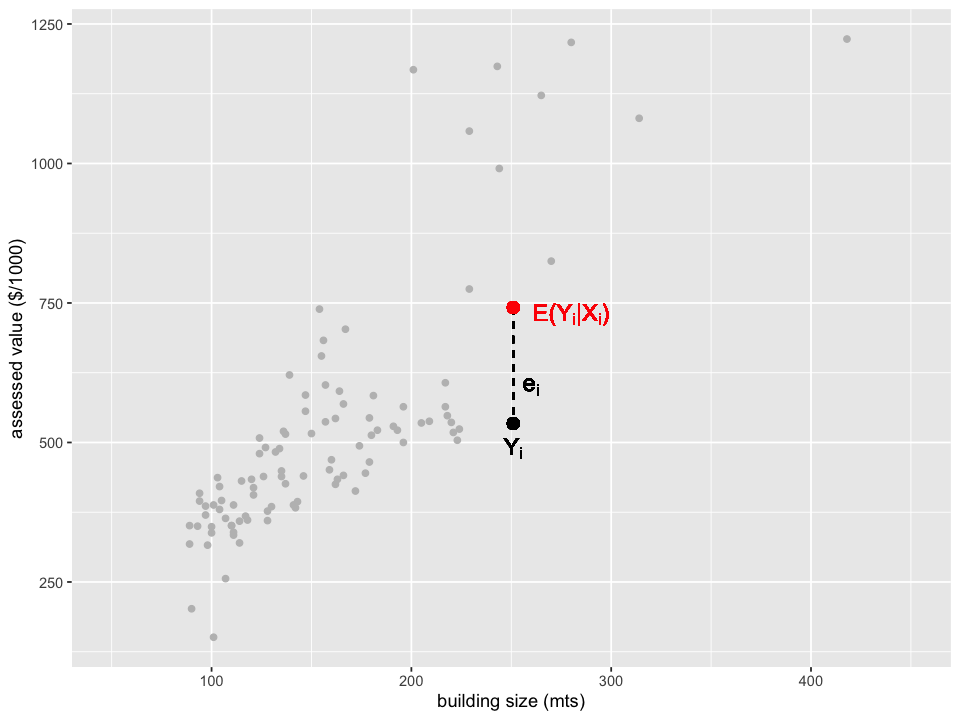

In [164]:
plot_expect

---

***b. Linear (model) assumption***

In addition, we have assumed that <b><font color=salmon>the conditional expectation is linear.</b></font> Then,

<font color=red> $$ E[Y_i|X_{i}] = \beta_0 + \beta_1 X_{i}$$ </font>


So we can write:

$$ Y_i = \beta_0 + \beta_1 X_{i} + \varepsilon_i$$

> in our example: the values of some houses are above the population line, the values of some houses are below the line

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 98 rows containing non-finite values (stat_smooth).”


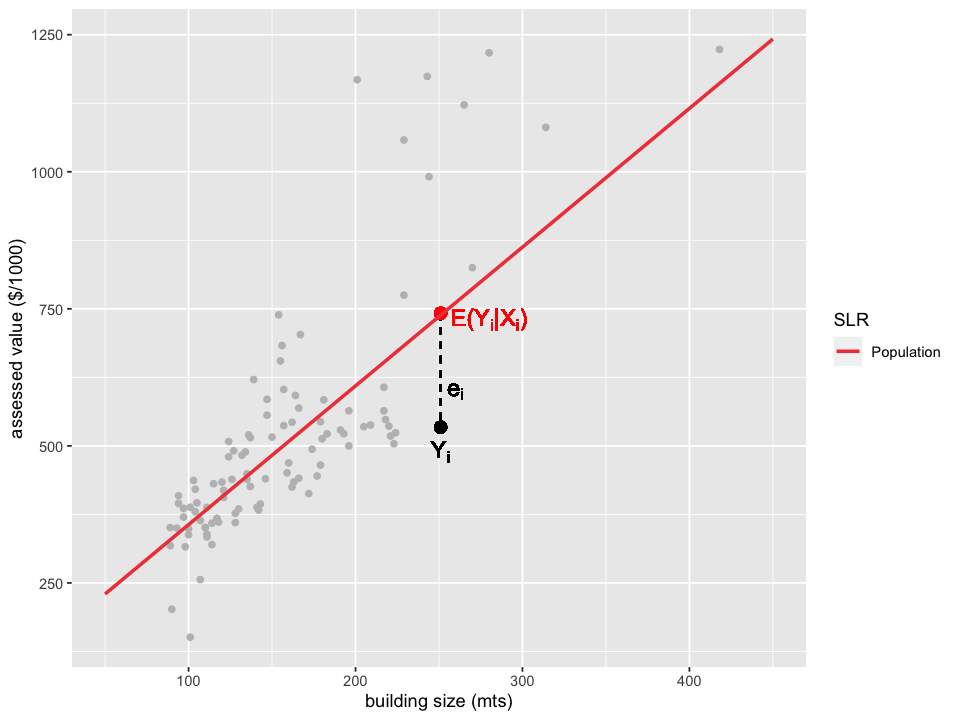

In [166]:
plot_i

---

***c. LR estimation***

Since the coefficients of the <font color=red> population LR (red line) </font> are *unknown*, we use the random sample to estimate them !!

> in ML, the set that we use to estimate the LR is called the training set

Then, we can use the <font color=blue> estimated LR (blue line) </font> to predict

> we can predict observations from the training or test sets! 

The prediction of the $i$-th observation is given by:

<font color=blue> $$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i} $$

---

***d. In plain language***

Based on a random sample of houses from Strathcona, we estimate the relation between the assessed value  of a house and its size.

<b><font color=salmon>We use the estimated relation to predict the value of any house in the county</b></font>


> <b><font color=salmon>Note</b></font>
> - the true population estimation $E(Y_i|X_i)$ might not be exactly on the red line (Population LR).

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 98 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'



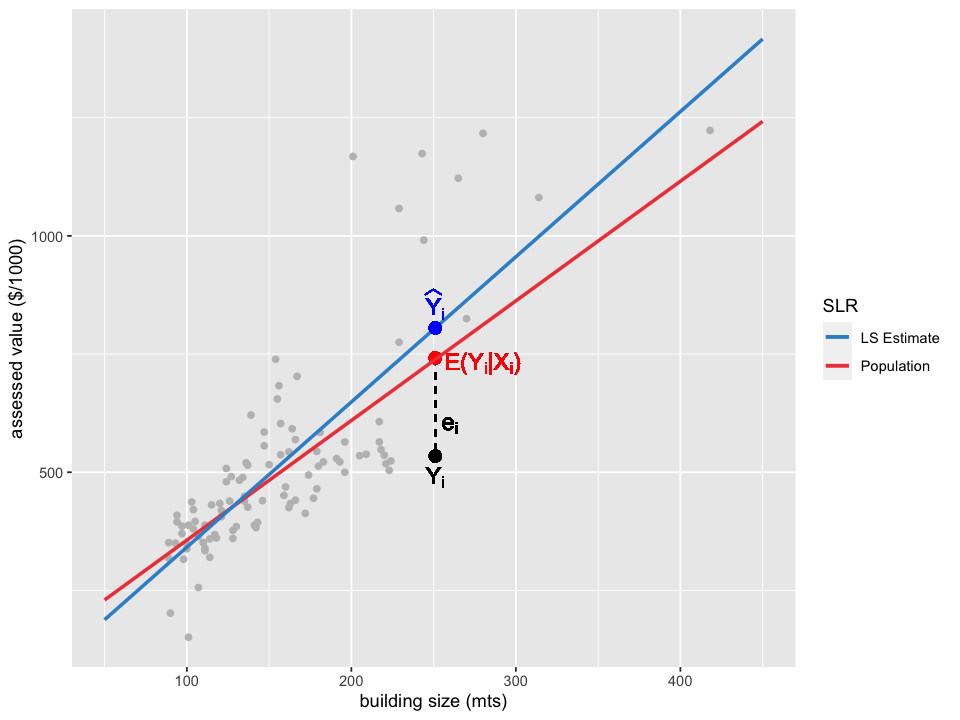

In [167]:
plot_ls

### 1). Goal

> What do we want to predict with <font color=blue> $\hat{Y}_i$ </font>??

- **(A)** the ***average*** assessed value of a house of *this size*: <b><font color=red> $E[Y_i|X_i]$, RED DOT</font><b>
    <font color=red> $$ E[Y_i|X_{i}] = \beta_0 + \beta_1 X_{i}$$ </font>
   

- **(B)** the ***actual*** value of a house of *this size*: <b><font color=BLACK> $Y_i$ (knowing its size $X_i$) BLACK DOT</font><b>
    
    $$ Y_i = \beta_0 + \beta_1 X_{i} + \varepsilon_i$$

> - Note that we predict both with *uncertainty*!! 
> - Which one do you think is harder to predict??

### 2). Confidence Intervals for Prediction (CIP)



#### a. Prediction goal

> **(A)** the ***average*** assessed value of a house of *this size*: <b><font color=red> $E[Y_i|X_i]$, RED DOT</font><b>
    <font color=red> $$ E[Y_i|X_{i}] = \beta_0 + \beta_1 X_{i}$$ </font>

The uncertainty comes from the estimation 

> only 1 sources of variation!

The predicted value <font color=blue> $ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i}$ </font> approximates, with uncertainty, the <font color=red> population $ E[Y_i| X_{i}] = \beta_0 + \beta_1 X_{i}$ </font>

> because the estimated coefficients <font color=blue> $\hat{\beta}_0$ and $\hat{\beta}_1$ </font> are estimates, *approximations*, of the true population coefficients <font color=red> $\beta_0$ and $\beta_1$ </font>, respectively

- if we take a different sample, we get different estimates, different blue lines, and different predictions!!

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 98 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”


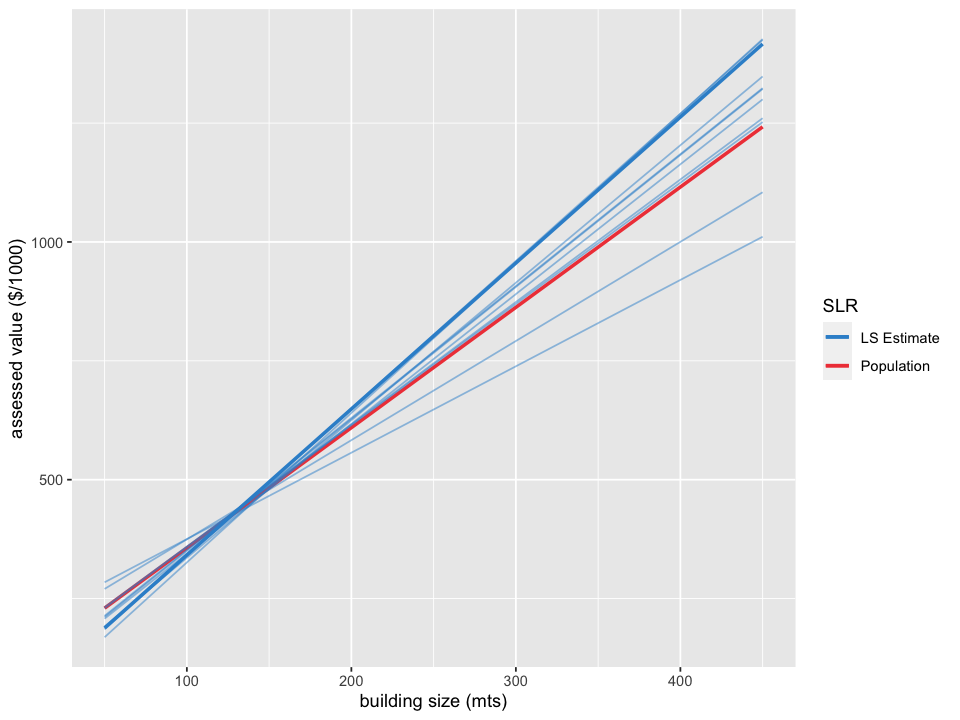

In [168]:
plot_add

#### b. CIP (confidence interval for prediction)

A **confidence interval for prediction** is a range that with probability 95% contains <font color=SALMON size = 3><b>the *average* value of a house of *this size*</b></font>

> - note that once we have estimated values and a numerical range based on the sample we use the word "confidence" since nothing else is random
> - CIP are centered at the fitted value  <font color=blue>$\hat{Y}_i$ </font>
> - classical intervals are based on the $t$-distribution (we omit details)

> each row corresponds to one (in-sample) prediction and its confidence interval

In [170]:
dat_cip <- dat_s %>%
  select(assess_val, BLDG_METRE) %>%
  cbind(predict(lm_s, interval = "confidence", se.fit = TRUE)$fit)


head(dat_cip,3)

,assess_val,BLDG_METRE,fit,lwr,upr
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,536,220,710.0708,671.9440,748.1977
2,370,97,332.3407,295.2144,369.4669
3,318,89,307.7729,267.9136,347.6321


<b><font color=salmon>NOTE:</b></font>

this is different from 


In [172]:
tidy(lm_s, conf.int = TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),34.455917,38.054823,0.9054284,3.674591e-01,-41.062641,109.974476
BLDG_METRE,3.070977,0.228401,13.4455485,5.610434e-24,2.617723,3.524231


#### c. interpretation

*Row 1*: with 95% confidence, we expect the average value of a house of size 220 mts to be between \\$671944 and \\$748198 (rounded)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 98 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'



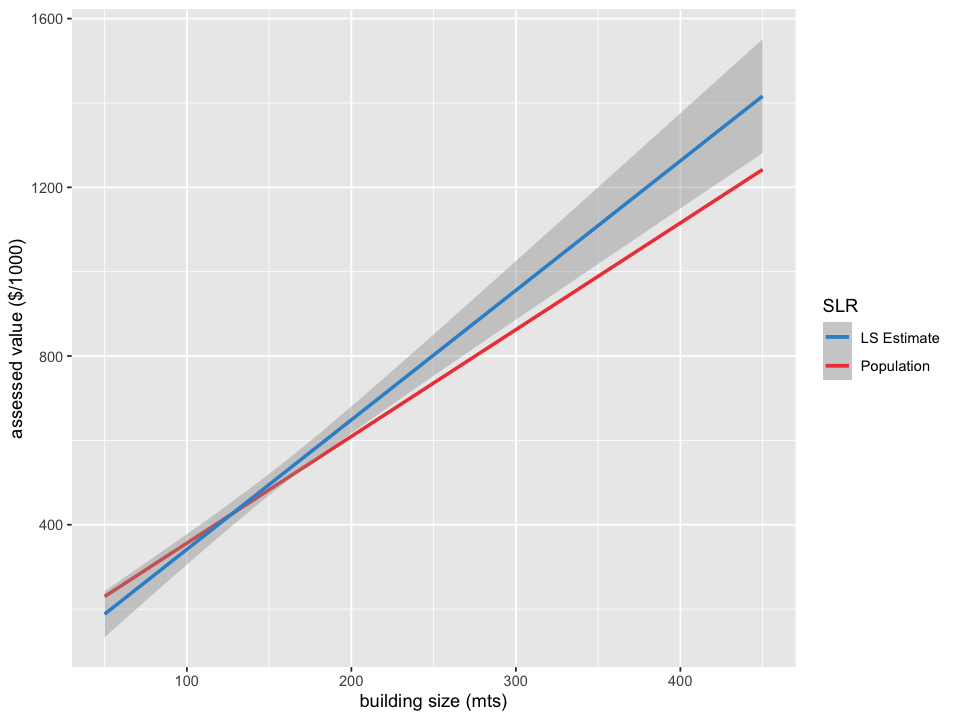

In [171]:
ggplot(data = dat_s, aes(BLDG_METRE, assess_val)) +
  xlab("building size (mts)") +
  ylab("assessed value ($/1000)") +
  xlim(50, 450) +
  geom_smooth(data = dat, aes(BLDG_METRE, assess_val, color = "Population"), method = lm, se = FALSE, fullrange = TRUE) +
  geom_smooth(data = dat_s, aes(BLDG_METRE, assess_val, color = "LS Estimate"), method = lm, se = TRUE, fullrange = TRUE) +
  scale_colour_manual(name = "SLR", values = cols)

### 3). Prediction Intervals (PI)


#### a. Prediction goal

> **(B)** the ***actual*** value of a house of *this size*: <b><font color=BLACK> $Y_i$ (knowing its size $X_i$) BLACK DOT</font><b>
    
$$ Y_i = \beta_0 + \beta_1 X_{i} + \varepsilon_i$$
    
The uncertainty comes from the estimation and from the error term that generates data!

> 2 sources of variation! more uncertainty!!
    
The predicted value <font color=blue> $ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i}$ </font> approximates, with uncertainty, the actual observation $ Y_i = \beta_0 + \beta_1 X_{i} + \varepsilon_i$

> **uncertainty 1**: because the estimated value <font color=blue> $\hat{\beta}_0 + \hat{\beta}_1 X_i$ </font> *approximates* the average (population) value $\beta_0 + \beta_1 X_i$ 

> **uncertainty 2**: because the actual observation $Y_i$ differs from the average (population) value by an error $\varepsilon_i$

> PI are centered at the fitted value  <font color=blue>$\hat{Y}_i$ </font>, but they are ***wider than the CIP (more uncertainty)***!


> classical intervals are based on the $t$-distribution (we omit details)

#### b. CIP (confidence interval for prediction)

A **prediction interval** is a range that with probability 95% contains <font color=SALMON size = 3><b>the *actual value* of a house of *this size* </b></font>

> each row corresponds to one (in-sample) prediction and its confidence interval

In [173]:
dat_pi <- dat_s %>%
  select(assess_val, BLDG_METRE) %>%
  cbind(predict.lm(lm_s, interval = "prediction"))

head(dat_pi, 3)

Warning message in predict.lm(lm_s, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


,assess_val,BLDG_METRE,fit,lwr,upr
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,536,220,710.0708,454.51943,965.6222
2,370,97,332.3407,76.93664,587.7447
3,318,89,307.7729,51.95726,563.5885


#### c. interpretation

*Row 1*: with 95% confidence, we the value of a house of size 220 mts to be between \\$454519 and \\$965622 (rounded)

### 4). In general:

<center>
<img src="img/pred_error.png" width=600/>
</center>


## 2. Assumption

### 1). Linearity

By *linear* in a LR, we mean that variables (or functions of them) are multiplied by a coefficient and then sum together

> mathematically this is called a linear combination

> this is sometimes emphasize by saying that the model is *linear in the coefficients* 

#### Another reasong for defining a LR beyond a linear visualization!!
Examples:

1. This is a LR: $Y_i=\beta_0 + \beta_1 X_{i} + \beta_2 X^2_{i} + \varepsilon_i$

> we can define $W_i = X^2_i$. Then, $Y_i=\beta_0 + \beta_1 X_{i} + \beta_2 W_{i} + \varepsilon_i$


2. This is a LR: $Y_i=\beta_0 + \beta_1 e^{X_{i}}  + \varepsilon_i$


> we can define $W_i = e^{X_{i}}$. Then, $Y_i=\beta_0 + \beta_1 X_{i} + \beta_2 W_{i} + \varepsilon_i$


3. This is a LR: $Y_i=\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i1}X_{i2}+ \varepsilon_i$


4. This is *not a LR*: $Y_i=e^{\beta_0 + \beta_1 X_{i1}}+ \varepsilon_i$

***Example from `mtcars`: fitting a quadratic function using LR***

> gas mileage in miles per gallon (`mpg`) versus horsepower (`hp`)

In [182]:
lr_l <- lm(mpg ~ hp, data = mtcars)

lr_quad <- lm(mpg ~ hp + I(hp^2), data = mtcars)

In [179]:
tidy(lr_quad)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),40.4091172029,2.740759e+00,14.743766,5.234398e-15
hp,-0.2133082599,3.488387e-02,-6.114812,1.162972e-06
I(hp^2),0.0004208156,9.844453e-05,4.274647,1.889240e-04


- green line is better

> BUT we made a linearity assumption:

### $$E[Y|X_1, \ldots, X_p]=\beta_0 + \beta_1 X_{1} + \ldots + \beta_p X_{p}$$

In real applications, the linear function is only an *approximation* of the conditional expectation!!

> if the true form is far from linear, then many of our conclusions may be flawed

> in particular, our prediction is no longer optimal!! and its accuracy may be seriously compromised!!

`geom_smooth()` using formula 'y ~ x'



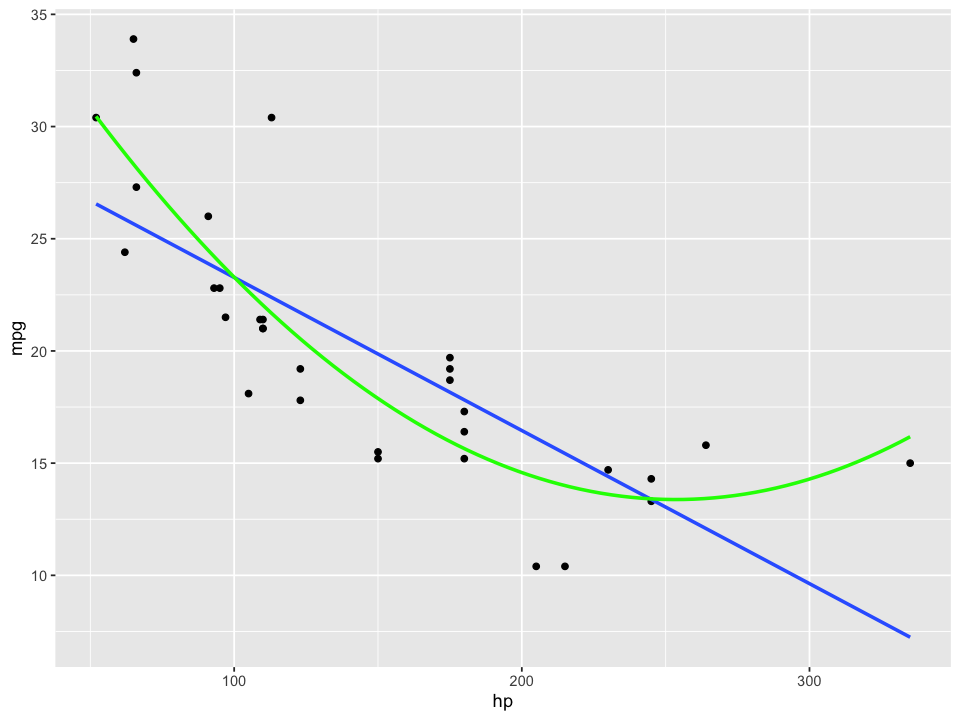

In [181]:
mtcars %>% ggplot(aes(x = hp, y = mpg)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), size = 1, color = "green", se = FALSE)

- check linearity

> Is there a way to check the linearity assumption??

#### The residuals plot

Plotting the residuals, $r_i = Y_i - \hat{Y}_i$ versus the fitted value in a $\hat{Y}_i$ is a useful way of identifying important information left in the error term that should be included in the model

> the residual plot should not show *any* pattern

> the presence of a pattern may indicate some sort of problem that we need to chase ...

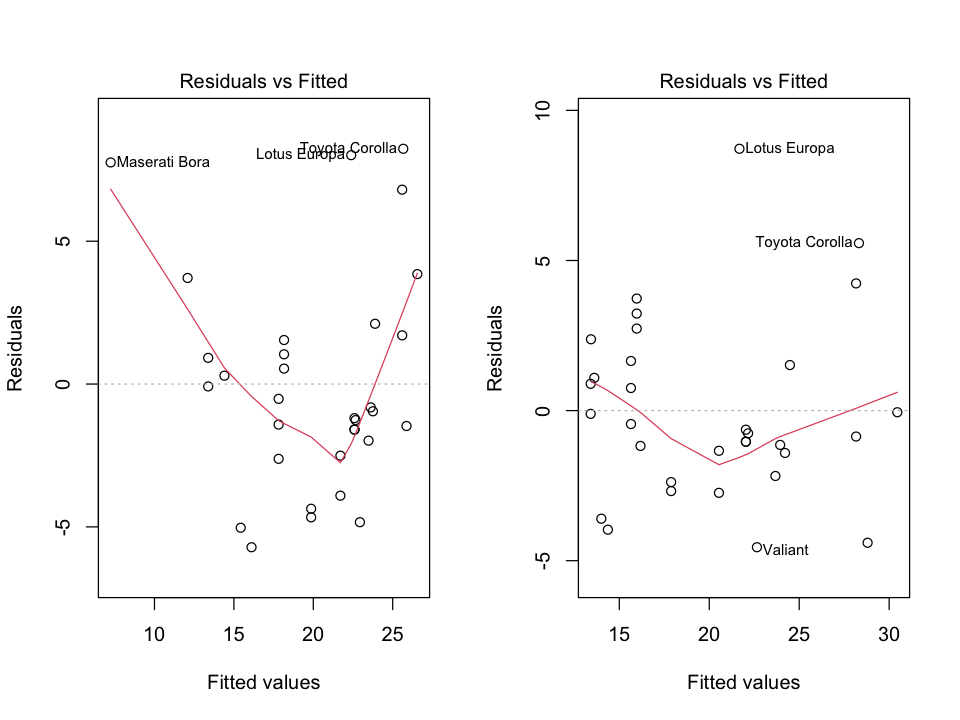

In [184]:
par(mfcol = c(1, 2))
plot(lr_l,1)
plot(lr_quad,1)

### 2). Normality assumption of the error term

***Least squares (LS) estimation does NOT depend on any Normality assumption***. We only need this assumption when we need the exact sampling distribution.

However, many of the inference results given by `lm` does!! (at least if sample size is not big enough for the CLT to kick in!!)

In addition, if the data is Normal, the conditional expectation is *linear*!!

Thus, people usually check on this assumption as well 

### The Q-Q plot

Compares the quantiles of the standard Normal Distribution with the empirical quantiles of the standardized residuals

> if the error term is approximately Normal, we expect most of the quantiles of both distributions to be approximately equal (over the 45 degree line in the plots)

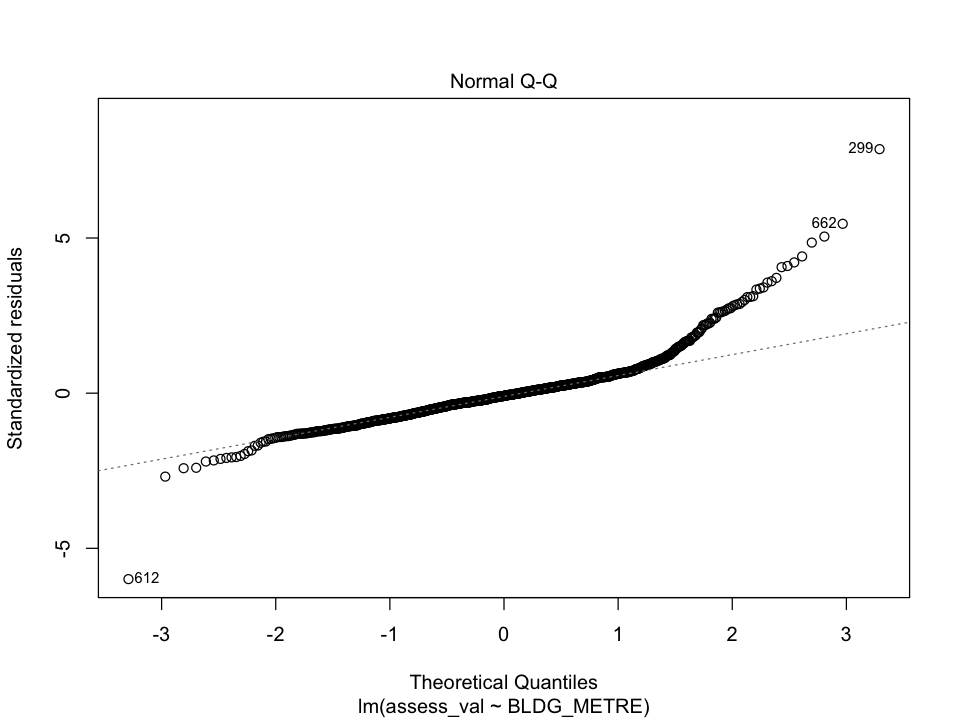

In [186]:
# Using the bigger smaller sample
set.seed(561)
dat_s <- sample_n(dat, 1000, replace = FALSE)
lm_large <- lm(assess_val ~ BLDG_METRE, dat_s)

plot(lm_large,2)

`geom_smooth()` using formula 'y ~ x'



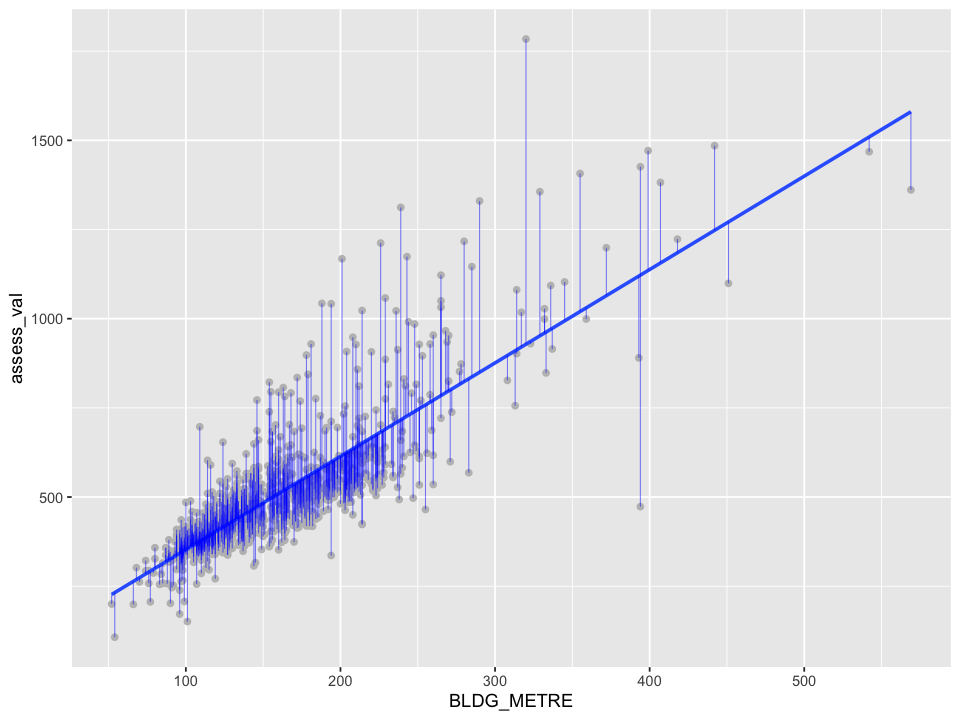

In [187]:
model.diag.metrics <- augment(lm_large)
ggplot(model.diag.metrics, aes(BLDG_METRE, assess_val)) +
  geom_point(color="grey") +
  stat_smooth(method = lm, se = FALSE) +
  geom_segment(aes(xend = BLDG_METRE, yend = .fitted), color = "blue", alpha=0.5,size = 0.3)

### 3). Equal variance

> also known as homogeneity, homoscedasticity, or constant variance assumption 

### We assumed that $\varepsilon_i$ are *iid*  

> independent and identically distributed 

### all with $E[\varepsilon_i]=0$, $Var[\varepsilon_i]=\sigma^2$, for all $i$

> note: independence will be relaxed in Time Series

Many of the estimation and prediction uncertainty results that we have seen rely on the assumption that $Var[\varepsilon_i]=\sigma^2$

> which we estimate with the RSE seen in lecture 07!!

- How do we check this assumption??

#### Back to the residual plot:

> if the assumption holds, we should see an even variation about the horizontal line at 0

> for example: you don't want to see a *funnel* effect: more variation for larger fitted values

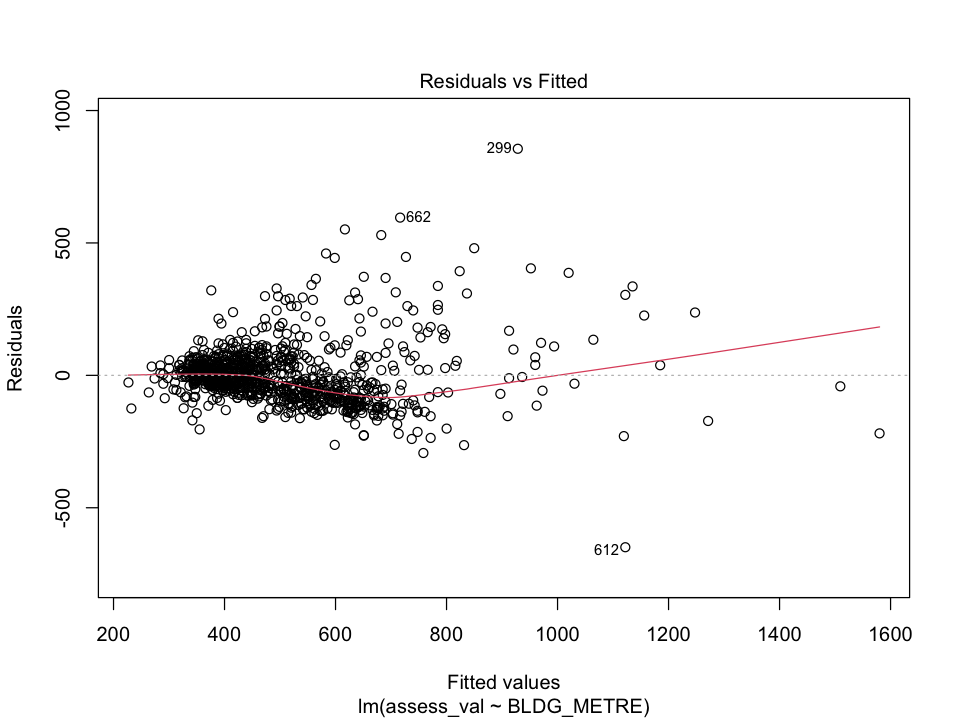

In [188]:
plot(lm_large,1)

## 3. Mulitcollinearity


In matrix notation , the least squares estimates satisfy: 

$\mathbf{X}^T\mathbf{X}\hat{\mathbf{\beta}}=\mathbf{X}^T\mathbf{Y}$

> if you are not familiar with matrices, just follow the idea. There's a way to check in R

If $\mathbf{X}^T\mathbf{X}$ is non-singular (analogous to $\neq 0$), then 

$\hat{\mathbf{\beta}}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}$


However, $\mathbf{X}^T\mathbf{X}$ becomes nearly singular or singular when explanatory variables are collinear or multicollinear, aka *multicollinearity problem*

- the solution $(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}$ becomes very unstable!! (e.g., values and sign of some coefficients change as variables are added)


- $Var(\hat{\mathbf{\beta}})=\hat{\sigma}^2(\mathbf{X}^T\mathbf{X})^{-1}$ so the SEs of $\hat{\mathbf{\beta}}$ can be large under multicollinearity

> similar effect as dividing by 0!



## Diagnosing multicollinearity

- Correlation between explanatory variables can be checked using pairwise plots

- Multicollinearity can be also measured through the variance inflation factors (VIF):

$\text{VIF}_j=\frac{1}{1-R^2_{X_j,\boldsymbol{X}_{-j}}}, \; j=1,\ldots,p$

> note $R^2_{X_j,\boldsymbol{X}_{-j}}$ measures how much of the observed variation of $X_j$ can be explained by other variables


If  $\text{VIF}_j >>1$, there is a sign of multicollinearity. Removing $X_j$ may alliviate the problem

> understanding the domain field of application helps to solve the problem by removing redundant variables

> Ridge, a penalized estimation method, has been proposed in 1970 as a remedy to LS under multicollinearity


In [183]:
li_hp <- 2 * mtcars$hp + 4

lr_multicol <- lm(mpg ~ hp + I(2 * mtcars$hp + 4), data = mtcars)

In [180]:
tidy(lr_multicol)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),30.09886054,1.6339210,18.421246,6.642736e-18
hp,-0.06822828,0.0101193,-6.742389,1.787835e-07
I(2 * mtcars$hp + 4),NA,NA,NA,NA


## 4. Summary

### Prediction uncertainty

- Confidence intervals for prediction account for the uncertainty given by the estimated LR to predict the conditional expectation of the response


- Prediction intervals account for the uncertainty given by the estimated LR to predict the conditional expectation of the response, *plus* the error that generates the data! 


- PI are wider than CIP, both are centered at the fitted value!


### Key assumptions to check:
    
- Linearity assumptions


- $\varepsilon_i \text{ are } iid \; E[\varepsilon_i]=0, \; V[\varepsilon_i]=\sigma$


- We don't need to assume normality to get LS estimates 


- We check Normality if we use it to construct CI and tests (assuming an exact sampling distribution)

- We don't need Normality if we approximate the sampling distribution with a *t*-distribution or using resampling techniques such as bootstrapping


- We assume that the explanatory variables are not collinear (largely correlated)

## 5. Poll questions

---
---

#### Q1: training vs test MSE
> The test MSE is used to evaluate out-of-sample prediction performance of a LR. In the absence of a test set, the training MSE is a good estimator of the test MSE. True or False?

> Answer: False 

- The training MSE underestimates the test MSE. The training set is used to estimate the LR coefficients. In particular, LS estimators minimize the MSE. Thus, by construction, we expect the training MSE to be low. This problem is usually refered as *overfitting*.
- In the absence of a test set, one can use cross-validation to divide the data into training set to estimate the model and test sets to evaluate it using out-of-sample data.
- Other estimators of the test MSE have been proposed, including the `C_p` Mallow, the `AIC` and the `BIC`. These methods penalized the RSS (based on the training set) to compensate the overfitting problem described above

---
---

#### Q2: AIC vs t-test

> In MLR, if all variables are significant, a variable selection procedure based on AIC will always select the full model. True or False?

> Answer: False

- <b><font color=salmon size=3.5>In MLR, the significance of each variable is determined by the `statistics` which is the size of the corresponding coefficient relative to its standard error using individual *t*-tests. </b></font>
- The AIC penalizes the RSS to determine how the model fit the data while taking into account its size.
- AIC may not select all variables, even if they are all significant, if a smaller model has a similar overall fit. 


---
---


#### Q3: nested models

> Your model has a categorical variable with 3 levels and a continuous variable. You want to test ***if a model with interaction is better than an additive model.*** Which tests results should you check?
> - (a) All t-tests given in the tidy table for the interaction terms
> - (b) An F-test computed by `anova` to compare both models
> - (c) The t- and the F- tests are equivalent

> Answer: (b), We need an F-test computed by `anova` to compare the additive *versus* the model with interaction.

The proposed model with interaction has 6 parameters to describe 3 intercepts and 3 slopes:

#### $$\text{prot}_i = \beta_0 + \beta_1 \text{mrna}_{i} + \beta_2 G2_{i}  + \beta_3 G3_{i}  + \beta_4 G2_{i} * \text{mrna}_{i} + \beta_5 G3_{i} * \text{mrna}_{i} +\varepsilon_i$$

- $\beta_0=0$: intercept of reference (level 1)
- $\beta_1=0$: slope of reference (level 1)
- $\beta_2=0$: difference of intercept of level 2 compared to intercept of level 1
- $\beta_3=0$: difference of intercept of level 3 compared to intercept of level 1
- $\beta_4=0$: difference of slope of level 2 compared to slope of level 1
- $\beta_5=0$: difference of slope of level 3 compared to slope of level 1

> *Recall that $\beta_2$ and $\beta_3$ are not intercepts, they are differences between intercepts!*

> *Recall that $\beta_4$ and $\beta_5$ are not slopes, they are differences between slopes!*


A model without interaction (additive) will have a unique, shared slope. So ***the null hypothesis to compare the additive model vs the model with interaction states that all slopes are equal.*** 

> If there's enough evidence to reject the null hypothesis that they are equal, then  model with interaction is better than the additive one 

<b><font color=salmon size=5>NOTE 1:</b></font>

we need to test if the last 2 coefficients (differences of slopes) are *simultaneously* equal to zero: $\beta_4=\beta_5=0$

> If $\beta_4=slope_2-slope_1=0$, then $slope_2=slope_1$. 

> ***And at the same time***, if $\beta_5=slope_3-slope_1=0$, then $slope_3=slope_1$. 

> ***Then, simulataneously!!!*** 
#### $$H_0: slope_1 = slope_2 = slope_3$$

- <font color=salmon size=3>To test if 2 coefficients are <b>*SIMULTANEOUSLY*</b> zero, we need an *F*-test!</font> 

### $$H_0: \beta_4=\beta_5=0$$

- The *t*-test tests if each of the coefficients separately equals zero:

$$H_0: \beta_4=0$$

and 

$$H_0:\beta_5=0$$

Although this seems a technical detail, in principle we are not testing the same thing. 

> For example, the first *t*-test evaluates if the slope of level 2 equals the slope of level 1 ($\beta_4=0$). However, the *F*-test evaluates if all 3 slopes are equal. 

<b><font color=salmon size=5>NOTE 2:</b></font>

if the categorical variable has only 2 levels, then the models includes only one dummy variable and we don't have a coefficient $\beta_5$. In that particular case, we test the same null hypothesis with both the *F*- and the *t*- tests:

$$H_0:\beta_4=0$$

and the tests are equivalent ($t^2 =F$). But this is not true in general.


---
---

#### Q4: variance of the error term

> In SLR, the `sigma` value given by the `glance` function is an estimate of the:
> - (a) Standard deviation of the error term
> - (b) Variance of the error term
> - (c) Standard error of the slope

> Answer: (a) 

As mentioned in lecture 8, an important assumption in LR is that the error terms are independent and identicall distributed random variables with 

#### $E[\varepsilon_i]=0$, $Var[\varepsilon_i]=\sigma^2$, for all $i$

> both the independence and the shared variance assumptions can be relaxed but that's beyond the scope of this course

Many of the estimation and prediction uncertainty results that we have seen rely on the assumption that $Var[\varepsilon_i]=\sigma^2$

In general, as many other quantities from the population, the variance of the error term $\sigma^2$ is *unknown*!! Thus, we estimate it from the data!!

> we estimate $\sigma^2$ with the RSE seen in lecture 07!!

### <font color=red> The function `glance` gives you an estimate of the standard deviation of the error term

> note that the Standard deviation is the square root of the variance of a random variable: $\sigma = \sqrt{Var[\varepsilon_i]}$
    
The estimators of a LR (including those of the slope(s)), $\hat{\beta}_j$ are also random variables! and we can measure their uncertainties with their standard errors!!
    
Although we did not prove this mathematical result, it can be shown that:
    
$$Var(\hat{\mathbf{\beta}})=\hat{\sigma}^2(\mathbf{X}^T\mathbf{X})^{-1}$$

> this is an estimated variance since we are estimating the true $\sigma^2$
    
> using matrix notation for those that have seen some Linear Algebra before
    
Note that the `lm` function in R computes the SE of the estimators of LR for you (square root of the variance)!! 
    
> as you can see they are calculated with an estimate of the variance of the error term: $\hat{\sigma}^2$, square of `sigma`
    
While the SE of the estimators of a LR depend on the estimated SD of the error term, these two things are not the same!!
    
> $SE(\hat{\beta}) \neq SD(\varepsilon)$  
    
> these are 2 different population quantities and their estimates are different as well!
    
> `sigma` in `glance` estimates the latter!    

In [165]:
glance(lm_full)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4405562,0.3473155,5.741013e-05,4.724937,0.002663059,5,303.7504,-593.5009,-582.4162,9.887768e-08,30,36


# DSCI561 Summary

---
---


### 2. estimates
<center>
<img src="img/estimates.png" width=300/>
</center>

### 3. CIs
<center>
<img src="img/all_ci.png" width=300/>
</center>

### 4. Assess the form you assume, we need
- info about the error term that we cannot compute
- but we can use residuals to estimate error term
- to have residuals, we need to fit the model and see the diff between the actual observation and the fitted value.


### 5. the meaning of all columns:

#### `tidy(lm_full)`
- `estimate`: estimated LR parameters.
- `std.error`: embed the variation between different samples, that can be measured by the standard error of the error term.
- `statistic`: used to test hypothesis about LR parameters.
- `p.value`: reject $H_0$ or not
    
#### `glance(lm_full)`
- `r.squared`: coefficient of determination, relative measure ESS/TSS
- `adj.r.squared`: solve the problem that $R^2$ increases as more variables are added to a model.
- `sigma`: Standard deviation of the error term calculated with residuals
- `statistic`: used to test hypothesis about LR parameters.
- `p.value`: reject $H_0$ or not
- `df`: degree of freedom
- `logLik`: ?
- `AIC`/`BIC`: Estimates of the test MSE
- ...

In [189]:
tidy(lm_full)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.327928e-06,5.577621e-05,0.1134521,0.9104280
geneENSG00000143553,3.201698e-05,8.589540e-05,0.3727439,0.7119597
geneENSG00000168497,6.906928e-05,6.174779e-05,1.1185709,0.2722003
mrna,2.057447e-01,5.890193e-01,0.3493004,0.7293038
geneENSG00000143553:mrna,-1.031184e+00,2.753427e+00,-0.3745094,0.7106597
geneENSG00000168497:mrna,8.982580e-01,8.473966e-01,1.0600207,0.2975953


In [190]:
glance(lm_full)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4405562,0.3473155,5.741013e-05,4.724937,0.002663059,5,303.7504,-593.5009,-582.4162,9.887768e-08,30,36
